In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PiNP_1D(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        self.latent_dim = latent_dim
        
        # --- 1. ENCODER (Compresión Probabilística) ---
        # Input: (x, t, s) -> 3 dimensiones
        self.encoder_net = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim * 2) # Salida: mu y log_var
        )
        
        # --- 2. DECODER (Generador Físico) ---
        # Input: (x_query, t_query) + z -> 2 + latent_dim dimensiones
        self.decoder_net = nn.Sequential(
            nn.Linear(2 + latent_dim, 64),
            nn.Tanh(), # Tanh es mejor para derivadas físicas suaves que ReLU
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 2) # Salida: [s (concentración), u (velocidad)]
        )

    def reparameterize(self, mu, log_var):
        """Truco de reparametrización para permitir backpropagation"""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_context, t_context, s_context, x_target, t_target):
        """
        Flow completo: Contexto -> Z -> Predicción Target
        """
        # Paso A: Encoding de cada punto de contexto individualmente
        # input shape: [Batch, N_points, 3]
        inputs = torch.cat([x_context, t_context, s_context], dim=-1)
        r_i = self.encoder_net(inputs) 
        
        # Paso B: Agregación (Promedio para ser Invariante a Permutaciones)
        r_agg = torch.mean(r_i, dim=1) # [Batch, latent_dim * 2]
        
        # Paso C: Espacio Latente
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        z = self.reparameterize(mu, log_var) # [Batch, latent_dim]
        
        # Paso D: Decoding (Concatenar z con coordenadas target)
        # Repetimos z para que coincida con el número de puntos target
        z_expanded = z.unsqueeze(1).repeat(1, x_target.size(1), 1)
        decoder_input = torch.cat([x_target, t_target, z_expanded], dim=-1)
        
        prediction = self.decoder_net(decoder_input)
        
        s_pred = prediction[..., 0:1] # Concentración
        u_pred = prediction[..., 1:2] # Velocidad (Latente/Oculta)
        
        return s_pred, u_pred, mu, log_var

# --- 3. LOSS FUNCTION FÍSICA (El corazón del método) ---

def physics_loss(model, x, t, z, kappa=0.01):
    """
    Calcula el residuo de la PDE: s_t + u * s_x - kappa * s_xx = 0
    """
    # Importante: habilitar gradientes para las entradas
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    # Predecir con el decoder usando el z fijo que viene del encoder
    z_expanded = z.unsqueeze(1).repeat(1, x.size(1), 1)
    decoder_input = torch.cat([x, t, z_expanded], dim=-1)
    prediction = model.decoder_net(decoder_input)
    
    s = prediction[..., 0:1]
    u = prediction[..., 1:2]
    
    # Derivadas de primer orden (Gradientes)
    s_x = torch.autograd.grad(s, x, torch.ones_like(s), create_graph=True)[0]
    s_t = torch.autograd.grad(s, t, torch.ones_like(s), create_graph=True)[0]
    
    # Derivadas de segundo orden (para difusión)
    s_xx = torch.autograd.grad(s_x, x, torch.ones_like(s_x), create_graph=True)[0]
    
    # Ecuación de Advección-Difusión 1D
    # Residual = s_t + u * s_x - kappa * s_xx
    # Nota: La red aprende 'u' para que esta ecuación se cumpla.
    residual = s_t + (u * s_x) - (kappa * s_xx)
    
    return torch.mean(residual**2)

# --- Ejemplo de uso Dummy ---
if __name__ == "__main__":
    # Datos simulados
    B, N_context, N_target = 4, 10, 50
    x_c = torch.rand(B, N_context, 1)
    t_c = torch.rand(B, N_context, 1)
    s_c = torch.rand(B, N_context, 1) # Datos observados
    
    x_target = torch.rand(B, N_target, 1)
    t_target = torch.rand(B, N_target, 1)
    
    model = PiNP_1D()
    
    # 1. Forward Pass
    s_hat, u_hat, mu, log_var = model(x_c, t_c, s_c, x_target, t_target)
    
    # 2. Cálculo de Losses
    # A. Reconstrucción (MSE en puntos conocidos si target incluye contexto, o supervisado)
    loss_rec = F.mse_loss(s_hat, torch.zeros_like(s_hat)) # Dummy target
    
    # B. KL Divergence (Regularización Bayesiana)
    loss_kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # C. Física (PDE Residual)
    # Volvemos a samplear z para el cálculo físico independiente
    z_sample = model.reparameterize(mu, log_var)
    loss_phy = physics_loss(model, x_target, t_target, z_sample)
    
    total_loss = loss_rec + 0.01 * loss_kl + 1.0 * loss_phy
    
    print(f"Loss Física: {loss_phy.item():.5f}")
    print("La red predijo s (humo) y u (velocidad) cumpliendo la PDE.")

Loss Física: 0.00114
La red predijo s (humo) y u (velocidad) cumpliendo la PDE.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PiNP_Heat_1D(nn.Module):
    def __init__(self, latent_dim=16):
        super().__init__()
        
        # --- 1. ENCODER ---
        # Input: (x, t, u_temp) -> Observaciones de temperatura
        self.encoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim * 2) # output: mu, log_var
        )
        
        # --- 2. DECODER ---
        # Input: (x_query, t_query) + z
        # Output: Solo u_temp (Temperatura)
        self.decoder = nn.Sequential(
            nn.Linear(2 + latent_dim, 32),
            nn.Tanh(), # Tanh es crucial para segundas derivadas (suavidad)
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1) # SALIDA ÚNICA: Temperatura
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_c, t_c, u_c, x_target, t_target):
        # A. Encoding
        inputs = torch.cat([x_c, t_c, u_c], dim=-1)
        r = self.encoder(inputs)
        r_agg = torch.mean(r, dim=1) # Agregación de contexto
        
        # B. Latent Space
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        # C. Decoding
        z_expanded = z.unsqueeze(1).repeat(1, x_target.size(1), 1)
        dec_input = torch.cat([x_target, t_target, z_expanded], dim=-1)
        
        u_pred = self.decoder(dec_input)
        
        return u_pred, mu, log_var

# --- 3. LOSS FUNCTION (Ecuación del Calor) ---

def heat_equation_loss(model, x, t, z, alpha=0.01):
    """
    Fuerza: u_t = alpha * u_xx
    """
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    # Predecir Temperatura con el z actual
    z_exp = z.unsqueeze(1).repeat(1, x.size(1), 1)
    dec_input = torch.cat([x, t, z_exp], dim=-1)
    u = model.decoder(dec_input)
    
    # Derivada temporal (u_t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    
    # Primera derivada espacial (u_x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    
    # Segunda derivada espacial (u_xx)
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    
    # El Residuo: u_t - alpha * u_xx
    residual = u_t - (alpha * u_xx)
    
    return torch.mean(residual**2)

# --- Loop de Prueba Rápido ---
if __name__ == "__main__":
    # Modelo
    model = PiNP_Heat_1D()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Datos Dummy (Batch=1, 20 puntos contexto, 100 puntos target)
    x_c = torch.rand(1, 20, 1)
    t_c = torch.rand(1, 20, 1)
    u_c = torch.rand(1, 20, 1) # Temperaturas observadas
    
    x_t = torch.rand(1, 100, 1) # Donde queremos predecir/validar física
    t_t = torch.rand(1, 100, 1)
    
    # Simulación de un paso de entrenamiento
    optimizer.zero_grad()
    
    # 1. Forward
    u_pred, mu, log_var = model(x_c, t_c, u_c, x_t, t_t)
    
    # 2. Loss de Datos (Reconstrucción) - Supongamos que tenemos target real dummy
    u_target_real = torch.zeros_like(u_pred) 
    loss_data = F.mse_loss(u_pred, u_target_real)
    
    # 3. Loss Físico
    z_sample = model.reparameterize(mu, log_var)
    loss_phy = heat_equation_loss(model, x_t, t_t, z_sample, alpha=0.1)
    
    # Total
    loss = loss_data + loss_phy
    loss.backward()
    optimizer.step()
    
    print(f"Loss Física calculada: {loss_phy.item():.6f}")

Loss Física calculada: 0.001481


Entrenando...
Step 0: Loss Rec=0.3886, Phy=0.0001


/var/folders/3v/8tc_vkkd3k1200bn3dbpzcvc0000gn/T/ipykernel_20032/4249556611.py:54: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  denom = np.sqrt(4 * alpha * t + 1)
/var/folders/3v/8tc_vkkd3k1200bn3dbpzcvc0000gn/T/ipykernel_20032/4249556611.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  numer = np.exp(-(x**2) / (4 * alpha * t + 1))


Step 200: Loss Rec=0.0796, Phy=0.0003
Step 400: Loss Rec=0.0015, Phy=0.0058
Step 600: Loss Rec=0.0012, Phy=0.0033
Step 800: Loss Rec=0.0005, Phy=0.0019
Step 1000: Loss Rec=0.0005, Phy=0.0010
Step 1200: Loss Rec=0.0005, Phy=0.0007
Step 1400: Loss Rec=0.0003, Phy=0.0006


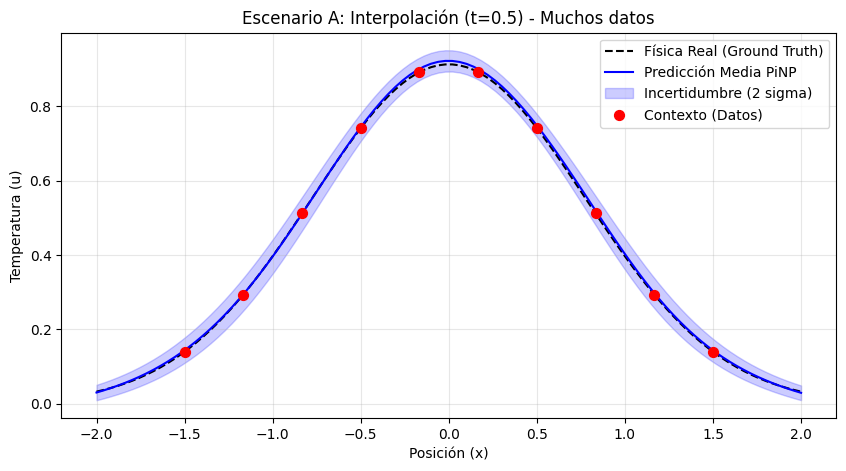

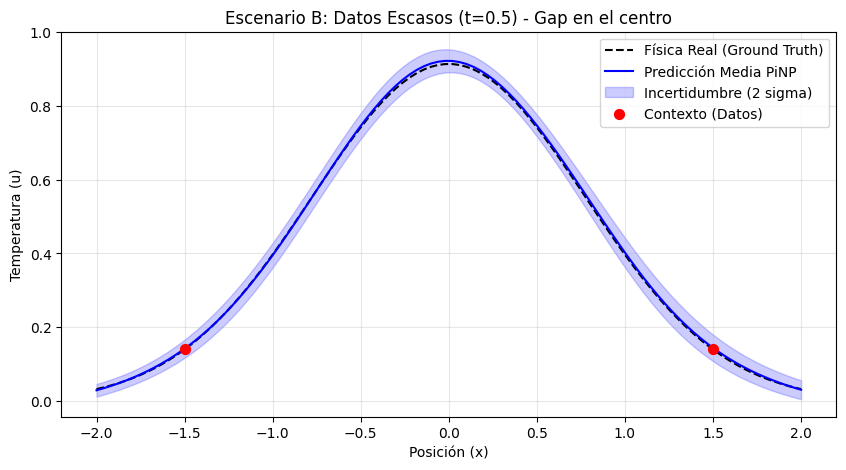


Generando Escenario C: Predicción a futuro sin datos futuros...


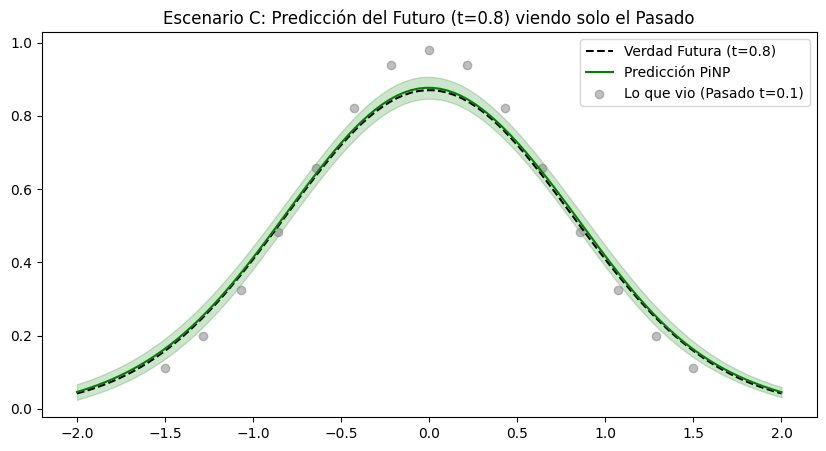

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. EL MODELO PiNP (Ecuación de Calor 1D)
# ==========================================
class PiNP_Heat_1D(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        # Encoder: (x, t, u) -> (mu, log_var)
        self.encoder = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, 64), nn.ReLU(),
            nn.Linear(64, latent_dim * 2)
        )
        # Decoder: (x, t, z) -> u
        self.decoder = nn.Sequential(
            nn.Linear(2 + latent_dim, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_c, t_c, u_c, x_target, t_target):
        # Codificar Contexto
        inputs = torch.cat([x_c, t_c, u_c], dim=-1)
        r = self.encoder(inputs)
        r_agg = torch.mean(r, dim=1) # Promedio (Permutation Invariant)
        
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        # Decodificar Target
        # Repetimos z para cada punto target
        z_expanded = z.unsqueeze(1).repeat(1, x_target.size(1), 1)
        dec_input = torch.cat([x_target, t_target, z_expanded], dim=-1)
        u_pred = self.decoder(dec_input)
        
        return u_pred, mu, log_var

# ==========================================
# 2. GENERADOR DE DATOS (Ground Truth)
# ==========================================
def heat_ground_truth(x, t, alpha=0.1):
    """Solución analítica: Decaimiento Gaussiano"""
    # u(x,t) = exp(-x^2 / (4*alpha*t + 1)) / sqrt(4*alpha*t + 1)
    denom = np.sqrt(4 * alpha * t + 1)
    numer = np.exp(-(x**2) / (4 * alpha * t + 1))
    return numer / denom

# Generamos un grid denso para evaluar
def get_data(batch_size=1, n_points=100):
    x = torch.linspace(-2, 2, n_points).view(1, -1, 1).repeat(batch_size, 1, 1)
    t = torch.linspace(0, 1, n_points).view(1, -1, 1).repeat(batch_size, 1, 1)
    # Mezclamos coordenadas para entrenamiento
    # Para simplificar graficas, usaremos t fijo luego, pero aqui generamos todo el dominio
    x_flat = (torch.rand(batch_size, n_points, 1) * 4) - 2 # Random x en [-2, 2]
    t_flat = torch.rand(batch_size, n_points, 1)           # Random t en [0, 1]
    u_flat = heat_ground_truth(x_flat, t_flat)
    return x_flat, t_flat, u_flat

# ==========================================
# 3. ENTRENAMIENTO RÁPIDO
# ==========================================
def train_model(model, steps=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    alpha_phy = 0.1 
    
    print("Entrenando...")
    for i in range(steps):
        # 1. Generar datos batch fresco (Batch=16, 50 puntos totales)
        x, t, u = get_data(batch_size=16, n_points=50)
        
        # --- CORRECCIÓN AQUÍ ---
        # En lugar de una máscara booleana, elegimos un número aleatorio de puntos
        # (entre 5 y 45) para usar como contexto en esta iteración.
        num_context = np.random.randint(5, 45)
        
        # Seleccionamos índices aleatorios y los aplicamos a todo el batch
        indices = torch.randperm(50)[:num_context]
        
        # Slicing: [Todas las filas, índices seleccionados, :]
        x_c = x[:, indices, :]
        t_c = t[:, indices, :]
        u_c = u[:, indices, :]
        # -----------------------

        # Forward (El target es x, t completos)
        u_pred, mu, log_var = model(x_c, t_c, u_c, x, t)
        
        # 1. Loss de Reconstrucción (MSE)
        rec_loss = F.mse_loss(u_pred, u)
        
        # 2. Loss KL (Regularización latente)
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
        
        # 3. Loss Físico (PDE Residual)
        z_phy = model.reparameterize(mu, log_var)
        
        # Puntos de colocación aleatorios para física
        x_phy = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        t_phy = (torch.rand(16, 50, 1)).requires_grad_(True)
        
        z_phy_exp = z_phy.unsqueeze(1).repeat(1, 50, 1)
        in_phy = torch.cat([x_phy, t_phy, z_phy_exp], dim=-1)
        u_phy_pred = model.decoder(in_phy)
        
        # Derivadas
        u_t = torch.autograd.grad(u_phy_pred, t_phy, torch.ones_like(u_phy_pred), create_graph=True)[0]
        u_x = torch.autograd.grad(u_phy_pred, x_phy, torch.ones_like(u_phy_pred), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_phy, torch.ones_like(u_x), create_graph=True)[0]
        
        res_phy = u_t - (alpha_phy * u_xx)
        phy_loss = torch.mean(res_phy**2)
        
        # Total Loss
        loss = rec_loss + 0.01 * kl_loss + 0.1 * phy_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Loss Rec={rec_loss.item():.4f}, Phy={phy_loss.item():.4f}")
# Inicializar y entrenar
model = PiNP_Heat_1D()
train_model(model, steps=1500)

# ==========================================
# 4. PLOTS DE COMPARACIÓN (La parte clave)
# ==========================================

def plot_scenario(title, context_x, context_u, target_t_val):
    """
    context_x/u: Puntos que la red "ve".
    target_t_val: Tiempo en el que queremos evaluar la predicción.
    """
    # Preparar datos de consulta (Query)
    # Queremos ver todo el eje X en un tiempo T específico
    x_plot = torch.linspace(-2, 2, 100).view(1, -1, 1)
    t_plot = torch.full((1, 100, 1), target_t_val)
    
    # Preparar contexto para la red
    # Nota: El contexto puede tener t mezclados, pero aquí asumimos un contexto simple
    # Creamos tensores torch
    x_c = torch.tensor(context_x, dtype=torch.float32).view(1, -1, 1)
    # Asumimos que el contexto viene del mismo tiempo T para facilitar la gráfica 2D,
    # aunque en realidad el modelo soporta t dispersos.
    t_c = torch.full((1, len(context_x), 1), target_t_val) 
    u_c = torch.tensor(context_u, dtype=torch.float32).view(1, -1, 1)
    
    # --- INFERENCIA PROBABILÍSTICA ---
    # Pasamos el contexto una vez para obtener mu y log_var
    with torch.no_grad():
        inputs = torch.cat([x_c, t_c, u_c], dim=-1)
        r = model.encoder(inputs)
        r_agg = torch.mean(r, dim=1)
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        
        # Sampleamos 30 veces el vector latente z para ver la incertidumbre
        predictions = []
        for _ in range(30):
            z_sample = model.reparameterize(mu, log_var)
            z_exp = z_sample.unsqueeze(1).repeat(1, 100, 1)
            dec_in = torch.cat([x_plot, t_plot, z_exp], dim=-1)
            pred = model.decoder(dec_in)
            predictions.append(pred.squeeze().numpy())
            
    predictions = np.array(predictions)
    mean_pred = predictions.mean(axis=0)
    std_pred = predictions.std(axis=0)
    
    # Ground Truth Real
    gt_u = heat_ground_truth(x_plot.numpy(), t_plot.numpy()).squeeze()
    
    # --- GRAFICAR ---
    plt.figure(figsize=(10, 5))
    plt.plot(x_plot.squeeze(), gt_u, 'k--', label='Física Real (Ground Truth)')
    plt.plot(x_plot.squeeze(), mean_pred, 'b-', label='Predicción Media PiNP')
    
    # Sombreado de Incertidumbre (+- 2 desviaciones estándar)
    plt.fill_between(x_plot.squeeze(), 
                     mean_pred - 2*std_pred, 
                     mean_pred + 2*std_pred, 
                     color='blue', alpha=0.2, label='Incertidumbre (2 sigma)')
    
    # Puntos de contexto (lo que la red vio)
    plt.scatter(context_x, context_u, c='red', s=50, zorder=5, label='Contexto (Datos)')
    
    plt.title(title)
    plt.xlabel('Posición (x)')
    plt.ylabel('Temperatura (u)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- ESCENARIO A: Interpolación Rica ---
# La red ve datos dispersos en el mismo instante T=0.5
t_val = 0.5
x_ctx = np.linspace(-1.5, 1.5, 10) # 10 puntos distribuidos
u_ctx = heat_ground_truth(x_ctx, np.full_like(x_ctx, t_val))
plot_scenario(f"Escenario A: Interpolación (t={t_val}) - Muchos datos", x_ctx, u_ctx, t_val)

# --- ESCENARIO B: Datos muy escasos (Gap grande) ---
# La red solo ve 2 puntos a los extremos, debe "inventar" el centro usando física
x_ctx = np.array([-1.5, 1.5]) 
u_ctx = heat_ground_truth(x_ctx, np.full_like(x_ctx, t_val))
plot_scenario(f"Escenario B: Datos Escasos (t={t_val}) - Gap en el centro", x_ctx, u_ctx, t_val)

# --- ESCENARIO C: Extrapolación Temporal (Magia) ---
# Entrenamos con datos generales, pero probemos:
# Le damos datos de t=0.1 (al inicio, pico alto) y pedimos predecir t=0.8 (futuro, aplanado)
# NOTA: Para graficar esto correctamente con la función de arriba, hay que ajustar el t_c y t_plot.
# Haremos un plot custom rápido para esto.

print("\nGenerando Escenario C: Predicción a futuro sin datos futuros...")
t_past = 0.1
t_future = 0.8
x_ctx = np.linspace(-1.5, 1.5, 15)
u_ctx = heat_ground_truth(x_ctx, np.full_like(x_ctx, t_past)) # Datos del PASADO

# Preparar tensores
x_plot = torch.linspace(-2, 2, 100).view(1, -1, 1)
t_plot_future = torch.full((1, 100, 1), t_future) # Queremos predecir FUTURO

# Contexto (Pasado)
x_c = torch.tensor(x_ctx, dtype=torch.float32).view(1, -1, 1)
t_c = torch.full((1, len(x_ctx), 1), t_past) # Contexto tiene t=0.1
u_c = torch.tensor(u_ctx, dtype=torch.float32).view(1, -1, 1)

with torch.no_grad():
    inputs = torch.cat([x_c, t_c, u_c], dim=-1)
    r_agg = torch.mean(model.encoder(inputs), dim=1)
    mu, log_var = torch.chunk(r_agg, 2, dim=-1)
    
    predictions = []
    for _ in range(30): # 30 samples
        z = model.reparameterize(mu, log_var)
        z_exp = z.unsqueeze(1).repeat(1, 100, 1)
        pred = model.decoder(torch.cat([x_plot, t_plot_future, z_exp], dim=-1))
        predictions.append(pred.squeeze().numpy())

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)
gt_future = heat_ground_truth(x_plot.numpy(), t_plot_future.numpy()).squeeze()

plt.figure(figsize=(10, 5))
plt.plot(x_plot.squeeze(), gt_future, 'k--', label=f'Verdad Futura (t={t_future})')
plt.plot(x_plot.squeeze(), mean_pred, 'g-', label='Predicción PiNP')
plt.fill_between(x_plot.squeeze(), mean_pred - 2*std_pred, mean_pred + 2*std_pred, color='green', alpha=0.2)
# Graficamos el contexto (lo que vio, que es del pasado) en gris tenue para referencia
plt.scatter(x_ctx, u_ctx, c='gray', alpha=0.5, label=f'Lo que vio (Pasado t={t_past})')

plt.title(f"Escenario C: Predicción del Futuro (t={t_future}) viendo solo el Pasado")
plt.legend()
plt.show()

Entrenando PiNP 2D...
Step 0: Loss Rec=0.0345, Phy=0.0000
Step 200: Loss Rec=0.0225, Phy=0.0000
Step 400: Loss Rec=0.0124, Phy=0.0001
Step 600: Loss Rec=0.0051, Phy=0.0012
Step 800: Loss Rec=0.0040, Phy=0.0016
Step 1000: Loss Rec=0.0016, Phy=0.0017
Step 1200: Loss Rec=0.0014, Phy=0.0031
Step 1400: Loss Rec=0.0010, Phy=0.0040
Step 1600: Loss Rec=0.0008, Phy=0.0023
Step 1800: Loss Rec=0.0008, Phy=0.0016


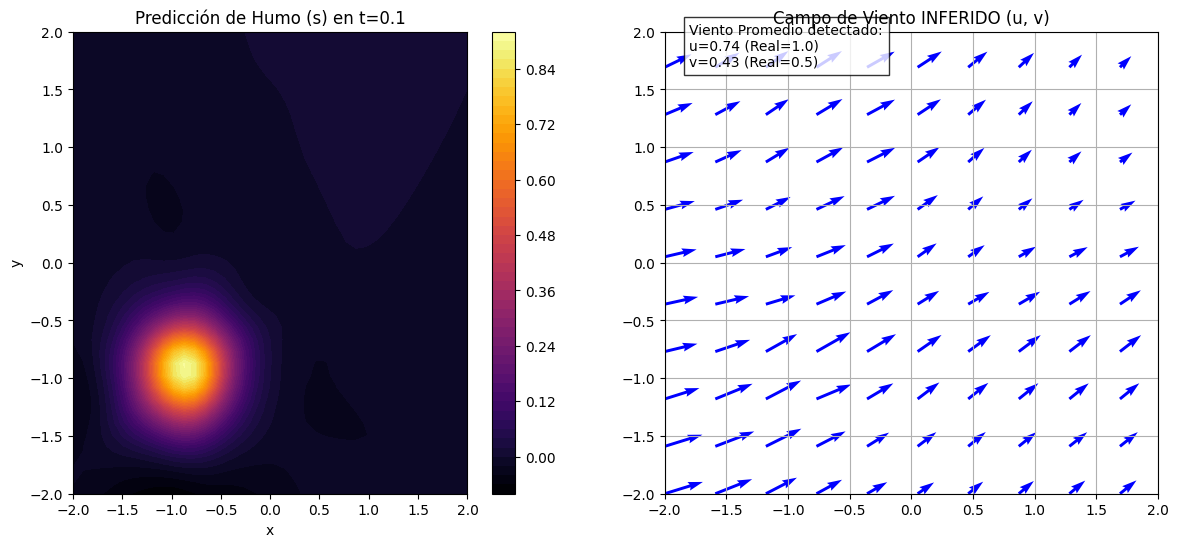

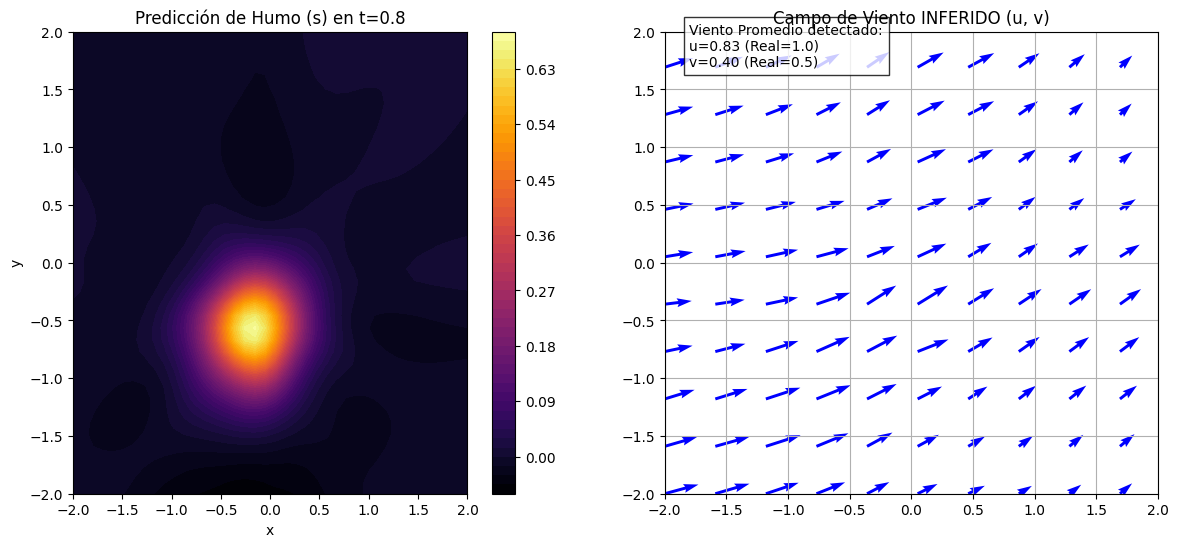

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. ARQUITECTURA PiNP 2D
# ==========================================
class PiNP_2D(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.latent_dim = latent_dim
        
        # --- ENCODER ---
        # Input: (x, y, t, s) -> 4 dimensiones
        # Representa: "En la pos (x,y) a tiempo t, la concentración es s"
        self.encoder = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim * 2) # mu, log_var
        )
        
        # --- DECODER ---
        # Input: (x_query, y_query, t_query) + z
        # Output: [s (humo), u (viento_x), v (viento_y)]
        # ¡La red predice el viento aunque no tengamos datos de él!
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 128),
            nn.Tanh(), # Tanh es vital para derivadas suaves en 2D
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 3) # Salida: [s, u, v]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x_c, y_c, t_c, s_c, x_target, y_target, t_target):
        # 1. Encoding (Contexto)
        inputs = torch.cat([x_c, y_c, t_c, s_c], dim=-1)
        r = self.encoder(inputs)
        r_agg = torch.mean(r, dim=1) # Pooling
        
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        # 2. Decoding (Target)
        # Expandir z para cada punto target
        z_exp = z.unsqueeze(1).repeat(1, x_target.size(1), 1)
        
        dec_input = torch.cat([x_target, y_target, t_target, z_exp], dim=-1)
        pred = self.decoder(dec_input)
        
        # Separamos las salidas
        s_pred = pred[..., 0:1] # Concentración
        u_pred = pred[..., 1:2] # Vel X estimada
        v_pred = pred[..., 2:3] # Vel Y estimada
        
        return s_pred, u_pred, v_pred, mu, log_var

# ==========================================
# 2. GENERADOR DE DATOS (Ground Truth)
# ==========================================
def get_2d_data(batch_size=8, n_points=200):
    """
    Simula una nube Gaussiana moviéndose con viento constante.
    Viento: u=1.0, v=0.5 (Se mueve a la derecha y un poco arriba)
    """
    # Espacio y Tiempo aleatorios
    x = (torch.rand(batch_size, n_points, 1) * 4) - 2 # [-2, 2]
    y = (torch.rand(batch_size, n_points, 1) * 4) - 2 # [-2, 2]
    t = torch.rand(batch_size, n_points, 1)           # [0, 1]
    
    # Parámetros físicos reales (Ground Truth)
    D = 0.05 # Difusión
    u_wind = 1.0
    v_wind = 0.5
    
    # Solución Analítica de Advección-Difusión Gaussiana
    # Centro de la nube se mueve: x0 + u*t
    x0, y0 = -1.0, -1.0 # Empieza abajo a la izquierda
    
    x_center = x0 + u_wind * t
    y_center = y0 + v_wind * t
    
    # Varianza crece con el tiempo (Difusión): sigma^2 = 2*D*t + sigma_0
    sigma_sq = 2 * D * t + 0.1
    
    exponent = -((x - x_center)**2 + (y - y_center)**2) / (2 * sigma_sq)
    s = torch.exp(exponent) / (2 * np.pi * sigma_sq)
    
    # Normalizar un poco s para que la red aprenda mejor (0 a 1 aprox)
    s = s / s.max()
    
    return x, y, t, s

# ==========================================
# 3. ENTRENAMIENTO (Con Loss Físico 2D)
# ==========================================
def physics_loss_2d(model, x, y, t, z, D=0.05):
    """Calcula el residuo de la PDE 2D"""
    x.requires_grad_(True)
    y.requires_grad_(True)
    t.requires_grad_(True)
    
    # Predecir con decoder
    z_exp = z.unsqueeze(1).repeat(1, x.size(1), 1)
    dec_in = torch.cat([x, y, t, z_exp], dim=-1)
    prediction = model.decoder(dec_in)
    
    s = prediction[..., 0:1]
    u = prediction[..., 1:2] # Viento aprendido
    v = prediction[..., 2:3] # Viento aprendido
    
    ones = torch.ones_like(s)
    
    # Primera derivada temporal
    s_t = torch.autograd.grad(s, t, ones, create_graph=True)[0]
    
    # Primeras derivadas espaciales (Gradiente)
    s_x = torch.autograd.grad(s, x, ones, create_graph=True)[0]
    s_y = torch.autograd.grad(s, y, ones, create_graph=True)[0]
    
    # Segundas derivadas espaciales (Laplaciano)
    s_xx = torch.autograd.grad(s_x, x, torch.ones_like(s_x), create_graph=True)[0]
    s_yy = torch.autograd.grad(s_y, y, torch.ones_like(s_y), create_graph=True)[0]
    
    # PDE: s_t + u*s_x + v*s_y - D*(s_xx + s_yy) = 0
    diffusion = D * (s_xx + s_yy)
    advection = (u * s_x) + (v * s_y)
    
    residual = s_t + advection - diffusion
    return torch.mean(residual**2)

def train_2d(model, steps=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Entrenando PiNP 2D...")
    for i in range(steps):
        # 1. Datos
        x, y, t, s = get_2d_data(batch_size=8, n_points=100)
        
        # 2. Contexto aleatorio (CORREGIDO con indices)
        num_ctx = np.random.randint(10, 50)
        indices = torch.randperm(100)[:num_ctx]
        
        x_c = x[:, indices, :]
        y_c = y[:, indices, :]
        t_c = t[:, indices, :]
        s_c = s[:, indices, :]
        
        # 3. Forward
        s_pred, u_pred, v_pred, mu, log_var = model(x_c, y_c, t_c, s_c, x, y, t)
        
        # 4. Losses
        rec_loss = F.mse_loss(s_pred, s) # Solo supervisamos 's' (humo), NO la velocidad
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
        
        # Loss Físico (Aquí es donde aprende u y v sin datos)
        z_phy = model.reparameterize(mu, log_var)
        
        # Puntos de colocación frescos para la física
        x_p = (torch.rand(8, 50, 1) * 4 - 2).requires_grad_(True)
        y_p = (torch.rand(8, 50, 1) * 4 - 2).requires_grad_(True)
        t_p = torch.rand(8, 50, 1).requires_grad_(True)
        
        phy_loss = physics_loss_2d(model, x_p, y_p, t_p, z_phy)
        
        # Regularización extra: Velocidad suave (para que no prediga ruido en u,v)
        # Queremos que u, v sean constantes o cambien poco (opcional pero ayuda)
        loss = rec_loss + 0.01 * kl_loss + 0.1 * phy_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Loss Rec={rec_loss.item():.4f}, Phy={phy_loss.item():.4f}")

# Inicializar
model = PiNP_2D()
train_2d(model, steps=2000)

# ==========================================
# 4. VISUALIZACIÓN (Mapas de Calor y Vectores)
# ==========================================
def plot_2d_results(time_snapshot=0.5):
    """
    Genera un heatmap del humo y un campo vectorial (flechas) del viento aprendido.
    """
    # Crear Grid para plotear
    grid_size = 40
    xs = np.linspace(-2, 2, grid_size)
    ys = np.linspace(-2, 2, grid_size)
    X, Y = np.meshgrid(xs, ys)
    
    # Aplanar para pasar por la red
    x_flat = torch.tensor(X.flatten(), dtype=torch.float32).view(1, -1, 1)
    y_flat = torch.tensor(Y.flatten(), dtype=torch.float32).view(1, -1, 1)
    t_flat = torch.full((1, grid_size*grid_size, 1), time_snapshot)
    
    # Crear un contexto dummy (observamos el humo en t=0.5)
    # Generamos datos sintéticos frescos para el contexto
    x_ctx_raw, y_ctx_raw, t_ctx_raw, s_ctx_raw = get_2d_data(1, 100)
    # Forzamos que el contexto sea cercano al tiempo del snapshot para mejor calidad visual
    # (En la práctica usarías los datos reales disponibles)
    t_ctx_raw = torch.full_like(t_ctx_raw, time_snapshot) 
    
    # Pasada por el modelo
    with torch.no_grad():
        inputs = torch.cat([x_ctx_raw, y_ctx_raw, t_ctx_raw, s_ctx_raw], dim=-1)
        r_agg = torch.mean(model.encoder(inputs), dim=1)
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        z = mu # Usamos la media para el plot (deterministic)
        
        z_exp = z.unsqueeze(1).repeat(1, x_flat.size(1), 1)
        dec_in = torch.cat([x_flat, y_flat, t_flat, z_exp], dim=-1)
        
        pred = model.decoder(dec_in)
        s_map = pred[..., 0].view(grid_size, grid_size).numpy()
        u_map = pred[..., 1].view(grid_size, grid_size).numpy()
        v_map = pred[..., 2].view(grid_size, grid_size).numpy()

    # --- PLOTS ---
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Concentración de Humo (S)
    c1 = ax[0].contourf(X, Y, s_map, levels=50, cmap='inferno')
    fig.colorbar(c1, ax=ax[0])
    ax[0].set_title(f'Predicción de Humo (s) en t={time_snapshot}')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    # 2. Campo de Velocidad Aprendido (u, v)
    # Hacemos un subsampling para que las flechas no saturen la imagen
    skip = 4
    ax[1].quiver(X[::skip, ::skip], Y[::skip, ::skip], 
                 u_map[::skip, ::skip], v_map[::skip, ::skip], color='blue')
    ax[1].set_title('Campo de Viento INFERIDO (u, v)')
    ax[1].set_xlim(-2, 2)
    ax[1].set_ylim(-2, 2)
    ax[1].grid(True)
    
    # Nota de texto
    avg_u = np.mean(u_map)
    avg_v = np.mean(v_map)
    ax[1].text(-1.8, 1.7, f"Viento Promedio detectado:\nu={avg_u:.2f} (Real=1.0)\nv={avg_v:.2f} (Real=0.5)", 
               bbox=dict(facecolor='white', alpha=0.8))

    plt.show()

# Ejecutar visualización
plot_2d_results(time_snapshot=0.1) # Inicio
plot_2d_results(time_snapshot=0.8) # Final (Humo movido)

Entrenando PiNP en t=[0.0, 0.5] (Datos limitados al pasado)...
Iter 0: Rec=0.0330, Phy=0.0002
Iter 500: Rec=0.0085, Phy=0.0031
Iter 1000: Rec=0.0006, Phy=0.0019
Iter 1500: Rec=0.0003, Phy=0.0008
Iter 2000: Rec=0.0003, Phy=0.0008

--- EVALUANDO FORECASTING EN t=1.0 ---
MSE PiNP: 0.01003
MSE GP:   0.08431
Mejora PiNP sobre GP: 8.4x


/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


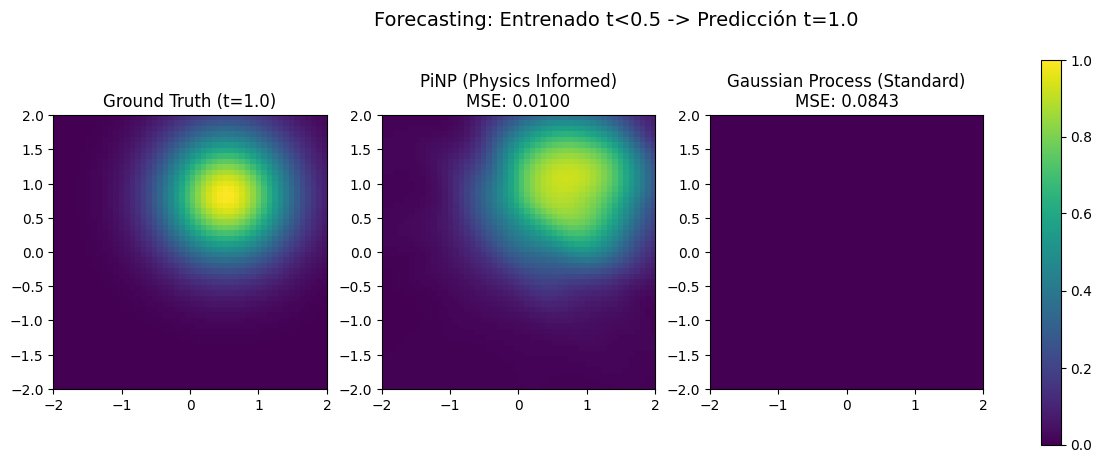

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Configuración de Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. GROUND TRUTH: EL VÓRTICE
# ==========================================
def vortex_ground_truth(x, y, t, D=0.2):
    """
    Simula una mancha de tinta rotando en un vórtice.
    Campo de velocidad: u = -y, v = x (Rotación antihoraria)
    """
    # Condición inicial (t=0): Mancha en (1, 0)
    x0, y0 = 1.0, 0.0
    
    # Trayectoria analítica de rotación
    # x(t) = x0 cos(t) - y0 sin(t)
    # y(t) = x0 sin(t) + y0 cos(t)
    # Como x0=1, y0=0:
    center_x = np.cos(t)
    center_y = np.sin(t)
    
    # Difusión: La mancha se agranda con el tiempo
    sigma = np.sqrt(0.05 + 2 * D * t)
    
    # Ecuación de la mancha Gaussiana
    dist_sq = (x - center_x)**2 + (y - center_y)**2
    s = np.exp(-dist_sq / (2 * sigma**2))
    return s

def get_data_batch(batch_size, n_points, t_min=0.0, t_max=1.0):
    # Genera puntos aleatorios en el dominio espacio-temporal
    x = (torch.rand(batch_size, n_points, 1) * 4) - 2 # [-2, 2]
    y = (torch.rand(batch_size, n_points, 1) * 4) - 2 # [-2, 2]
    t = torch.rand(batch_size, n_points, 1) * (t_max - t_min) + t_min
    
    # Calcular valores reales
    s_np = vortex_ground_truth(x.numpy(), y.numpy(), t.numpy())
    s = torch.tensor(s_np, dtype=torch.float32)
    
    return x, y, t, s

# ==========================================
# 2. MODELO PiNP (Physics-Informed Neural Process)
# ==========================================
class PiNP_Vortex(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder: (x, y, t, s) -> z
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        # Decoder: (x, y, t, z) -> s, u, v
        # Predecimos s (humo) Y u,v (velocidad oculta)
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 3) # Salida: [s, u, v]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        # Encoding
        ctx = torch.cat([xc, yc, tc, sc], dim=-1)
        r = self.encoder(ctx)
        mu, log_var = torch.chunk(torch.mean(r, dim=1), 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        z_exp = z.unsqueeze(1).repeat(1, xt.size(1), 1)
        target_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
        pred = self.decoder(target_in)
        
        return pred[..., 0:1], pred[..., 1:2], pred[..., 2:3], mu, log_var

# --- LOSS FÍSICO (ADVECCIÓN-DIFUSIÓN) ---
def physics_loss(model, x, y, t, z, D=0.02):
    x.requires_grad_(True); y.requires_grad_(True); t.requires_grad_(True)
    
    z_exp = z.unsqueeze(1).repeat(1, x.size(1), 1)
    pred = model.decoder(torch.cat([x, y, t, z_exp], dim=-1))
    s, u, v = pred[..., 0:1], pred[..., 1:2], pred[..., 2:3]
    
    # Derivadas automáticas
    grads = torch.ones_like(s)
    s_t = torch.autograd.grad(s, t, grads, create_graph=True)[0]
    s_x = torch.autograd.grad(s, x, grads, create_graph=True)[0]
    s_y = torch.autograd.grad(s, y, grads, create_graph=True)[0]
    s_xx = torch.autograd.grad(s_x, x, torch.ones_like(s_x), create_graph=True)[0]
    s_yy = torch.autograd.grad(s_y, y, torch.ones_like(s_y), create_graph=True)[0]
    
    # Residuo PDE: s_t + u*s_x + v*s_y - D*laplaciano = 0
    res = s_t + (u * s_x + v * s_y) - D * (s_xx + s_yy)
    return torch.mean(res**2)

# ==========================================
# 3. ENTRENAMIENTO (SOLO DATOS DEL PASADO)
# ==========================================
def train_pinp():
    model = PiNP_Vortex()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Entrenando PiNP en t=[0.0, 0.5] (Datos limitados al pasado)...")
    
    for i in range(2500):
        # Entrenamos solo con t entre 0.0 y 0.5
        x, y, t, s = get_data_batch(16, 100, t_min=0.0, t_max=0.5)
        
        # Contexto Random
        n_ctx = np.random.randint(10, 50)
        idx = torch.randperm(100)[:n_ctx]
        xc, yc, tc, sc = x[:, idx], y[:, idx], t[:, idx], s[:, idx]
        
        # Forward
        s_pred, u_pred, v_pred, mu, log_var = model(xc, yc, tc, sc, x, y, t)
        
        # Losses
        rec_loss = F.mse_loss(s_pred, s)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Physics Loss (Puede evaluar puntos en el futuro para aprender dinámica!)
        # Aquí está la clave: Evaluamos la física en t hasta 0.8 aunque no tengamos datos
        xp = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        yp = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        tp = (torch.rand(16, 50, 1) * 0.8).requires_grad_(True) # Física hasta t=0.8
        
        z_sample = model.reparameterize(mu, log_var)
        phy_loss = physics_loss(model, xp, yp, tp, z_sample)
        
        total_loss = rec_loss + 0.01 * kl_loss + 0.1 * phy_loss
        
        opt.zero_grad()
        total_loss.backward()
        opt.step()
        
        if i % 500 == 0:
            print(f"Iter {i}: Rec={rec_loss.item():.4f}, Phy={phy_loss.item():.4f}")
            
    return model

# ==========================================
# 4. ENTRENAMIENTO GAUSSIAN PROCESS (GP)
# ==========================================
def train_gp(context_points):
    """
    Entrena un GP estándar con los mismos puntos de contexto que vería la red.
    """
    # Kernel: RBF (espacial/temporal) + WhiteNoise
    kernel = 1.0 * RBF(length_scale=[1.0, 1.0, 0.5]) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=2)
    
    # Inputs: [x, y, t], Output: s
    X_train = context_points[:, :3] # x, y, t
    y_train = context_points[:, 3]  # s
    
    gp.fit(X_train, y_train)
    return gp

# ==========================================
# 5. EVALUACIÓN DE FORECASTING (COMPARACIÓN)
# ==========================================
def compare_forecasting(model, t_forecast=0.8):
    print(f"\n--- EVALUANDO FORECASTING EN t={t_forecast} ---")
    
    # 1. Crear Contexto (Datos del pasado t=0.0 a 0.2)
    # Generamos 50 puntos de observación ruidosos
    xc, yc, tc, sc = get_data_batch(1, 50, t_min=0.0, t_max=0.2)
    
    # Datos para GP (numpy)
    context_np = torch.cat([xc, yc, tc, sc], dim=-1).squeeze().numpy()
    
    # 2. Entrenar GP "on the fly" con estos datos
    gp_model = train_gp(context_np)
    
    # 3. Preparar Grid de Test en el FUTURO (t=0.8)
    grid_size = 50
    vals = np.linspace(-2, 2, grid_size)
    X_grid, Y_grid = np.meshgrid(vals, vals)
    
    x_flat = torch.tensor(X_grid.flatten(), dtype=torch.float32).view(1, -1, 1)
    y_flat = torch.tensor(Y_grid.flatten(), dtype=torch.float32).view(1, -1, 1)
    t_flat = torch.full_like(x_flat, t_forecast)
    
    # Ground Truth Futuro
    s_true_np = vortex_ground_truth(X_grid, Y_grid, t_forecast)
    
    # --- PREDICCIÓN PiNP ---
    with torch.no_grad():
        s_pinp, _, _, _, _ = model(xc, yc, tc, sc, x_flat, y_flat, t_flat)
        s_pinp_grid = s_pinp.view(grid_size, grid_size).numpy()

    # --- PREDICCIÓN GP ---
    # GP Input: [x, y, t_forecast]
    gp_in = np.stack([X_grid.flatten(), Y_grid.flatten(), np.full(grid_size**2, t_forecast)], axis=1)
    s_gp_flat, _ = gp_model.predict(gp_in, return_std=True)
    s_gp_grid = s_gp_flat.reshape(grid_size, grid_size)
    
    # --- METRICAS ---
    mse_pinp = np.mean((s_pinp_grid - s_true_np)**2)
    mse_gp = np.mean((s_gp_grid - s_true_np)**2)
    print(f"MSE PiNP: {mse_pinp:.5f}")
    print(f"MSE GP:   {mse_gp:.5f}")
    print(f"Mejora PiNP sobre GP: {mse_gp / mse_pinp:.1f}x")

    # --- PLOTS ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    vmin, vmax = 0, 1.0
    
    # Ground Truth
    im1 = axes[0].imshow(s_true_np, extent=[-2,2,-2,2], origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"Ground Truth (t={t_forecast})")
    
    # PiNP
    im2 = axes[1].imshow(s_pinp_grid, extent=[-2,2,-2,2], origin='lower', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"PiNP (Physics Informed)\nMSE: {mse_pinp:.4f}")
    
    # GP
    im3 = axes[2].imshow(s_gp_grid, extent=[-2,2,-2,2], origin='lower', vmin=vmin, vmax=vmax)
    axes[2].set_title(f"Gaussian Process (Standard)\nMSE: {mse_gp:.4f}")
    
    plt.suptitle(f"Forecasting: Entrenado t<0.5 -> Predicción t={t_forecast}", fontsize=14)
    plt.colorbar(im3, ax=axes.ravel().tolist())
    plt.show()

# Ejecución Principal
if __name__ == "__main__":
    # 1. Entrenar PiNP
    trained_model = train_pinp()
    
    # 2. Comparar
    # Forecasting cercano (t=0.6, justo después del training)
    # compare_forecasting(trained_model, t_forecast=0.6)
    
    # Forecasting lejano (t=1.0, el GP debería fallar estrepitosamente aquí)
    compare_forecasting(trained_model, t_forecast=1.0)


--- EVALUANDO FORECASTING EN t=1.0 ---
MSE PiNP: 0.00925
MSE GP:   0.09127
Mejora PiNP sobre GP: 9.9x


/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


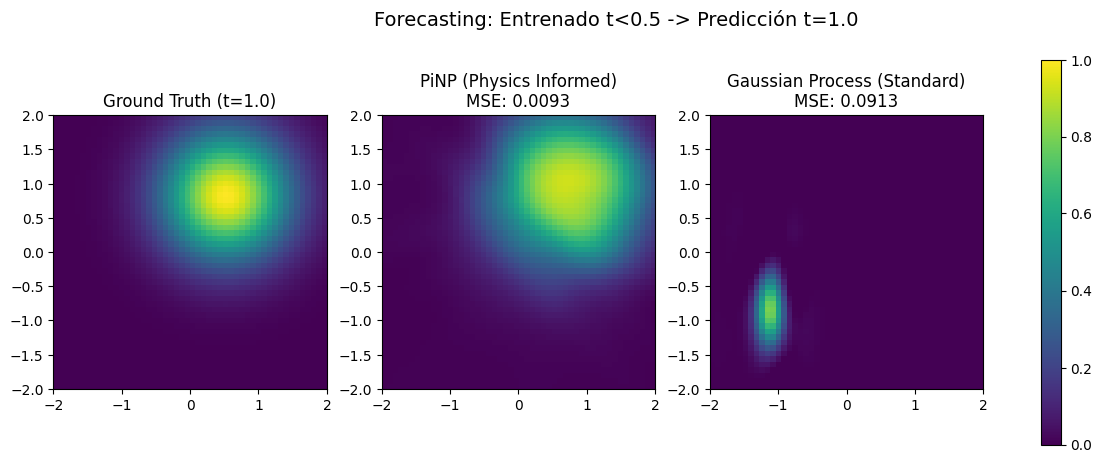

In [48]:
compare_forecasting(trained_model, t_forecast=1.0)

Entrenando con datos del PASADO (t < 0.5)...
Step 0: Rec=0.0201, Phy=0.0002
Step 500: Rec=0.0082, Phy=0.0000
Step 1000: Rec=0.0024, Phy=0.0012

--- FORECASTING t=0.9 (Datos vistos hasta t=0.5) ---


/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


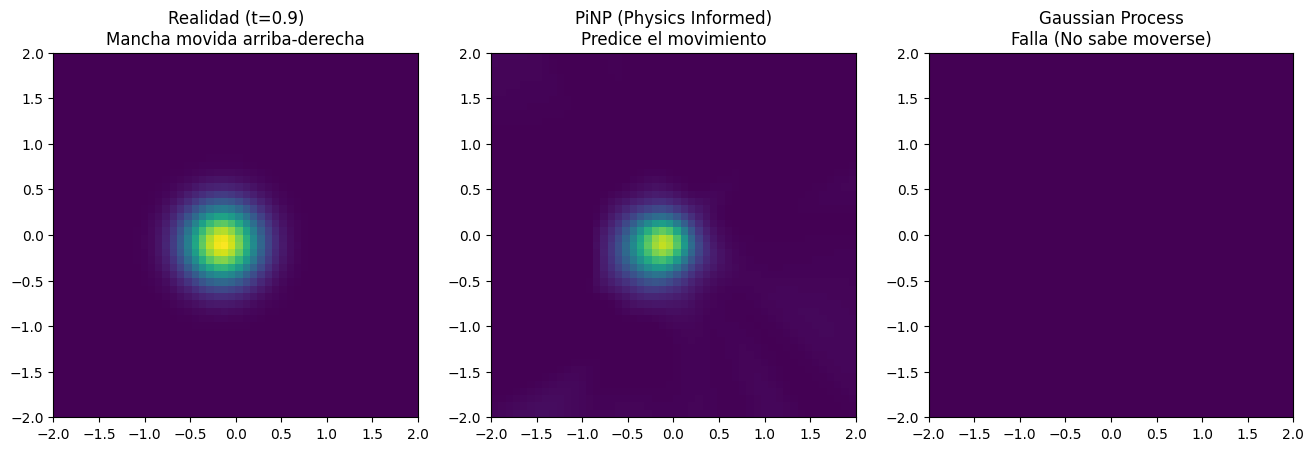

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. GROUND TRUTH: ADVECCIÓN LINEAL
# ==========================================
def advection_ground_truth(x, y, t, D=0.02):
    """
    Simula una mancha moviéndose en diagonal.
    Velocidad constante: u=1.5, v=1.0
    """
    # Velocidad del viento (Constante)
    u_vel = 1.5
    v_vel = 1.0
    
    # Condición inicial (t=0): Mancha en (-1.5, -1.0)
    x0, y0 = -1.5, -1.0
    
    # Trayectoria: x = x0 + u*t
    center_x = x0 + u_vel * t
    center_y = y0 + v_vel * t
    
    # Difusión (se expande un poco)
    sigma = np.sqrt(0.05 + 2 * D * t)
    
    # Gaussiana
    dist_sq = (x - center_x)**2 + (y - center_y)**2
    s = np.exp(-dist_sq / (2 * sigma**2))
    return s

def get_data_batch(batch_size, n_points, t_min=0.0, t_max=1.0):
    x = (torch.rand(batch_size, n_points, 1) * 4) - 2
    y = (torch.rand(batch_size, n_points, 1) * 4) - 2
    t = torch.rand(batch_size, n_points, 1) * (t_max - t_min) + t_min
    
    s_np = advection_ground_truth(x.numpy(), y.numpy(), t.numpy())
    s = torch.tensor(s_np, dtype=torch.float32)
    return x, y, t, s

# ==========================================
# 2. MODELO PiNP (Igual que antes)
# ==========================================
class PiNP_Advection(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 3) # s, u, v
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        ctx = torch.cat([xc, yc, tc, sc], dim=-1)
        r = self.encoder(ctx)
        mu, log_var = torch.chunk(torch.mean(r, dim=1), 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        z_exp = z.unsqueeze(1).repeat(1, xt.size(1), 1)
        target_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
        pred = self.decoder(target_in)
        return pred[..., 0:1], pred[..., 1:2], pred[..., 2:3], mu, log_var

# Loss Físico
def physics_loss(model, x, y, t, z, D=0.02):
    x.requires_grad_(True); y.requires_grad_(True); t.requires_grad_(True)
    
    z_exp = z.unsqueeze(1).repeat(1, x.size(1), 1)
    pred = model.decoder(torch.cat([x, y, t, z_exp], dim=-1))
    s, u, v = pred[..., 0:1], pred[..., 1:2], pred[..., 2:3]
    
    grads = torch.ones_like(s)
    s_t = torch.autograd.grad(s, t, grads, create_graph=True)[0]
    s_x = torch.autograd.grad(s, x, grads, create_graph=True)[0]
    s_y = torch.autograd.grad(s, y, grads, create_graph=True)[0]
    s_xx = torch.autograd.grad(s_x, x, torch.ones_like(s_x), create_graph=True)[0]
    s_yy = torch.autograd.grad(s_y, y, torch.ones_like(s_y), create_graph=True)[0]
    
    # Residuo PDE
    res = s_t + (u * s_x + v * s_y) - D * (s_xx + s_yy)
    return torch.mean(res**2)

# ==========================================
# 3. ENTRENAMIENTO (Restringido al Pasado)
# ==========================================
def train_pinp():
    model = PiNP_Advection()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Entrenando con datos del PASADO (t < 0.5)...")
    
    for i in range(1500):
        # Datos observables solo hasta t=0.5
        x, y, t, s = get_data_batch(16, 80, t_min=0.0, t_max=0.5)
        
        # Contexto Random
        n_ctx = np.random.randint(10, 40)
        idx = torch.randperm(80)[:n_ctx]
        xc, yc, tc, sc = x[:, idx], y[:, idx], t[:, idx], s[:, idx]
        
        s_pred, _, _, mu, log_var = model(xc, yc, tc, sc, x, y, t)
        
        rec_loss = F.mse_loss(s_pred, s)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Loss Físico: Evaluamos física un poco más allá de los datos (hasta t=0.7)
        # Esto ayuda a "empujar" la dinámica hacia el futuro
        xp = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        yp = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        tp = (torch.rand(16, 50, 1) * 0.7).requires_grad_(True)
        
        z_sample = model.reparameterize(mu, log_var)
        phy_loss = physics_loss(model, xp, yp, tp, z_sample)
        
        loss = rec_loss + 0.01 * kl_loss + 0.1 * phy_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 500 == 0:
            print(f"Step {i}: Rec={rec_loss.item():.4f}, Phy={phy_loss.item():.4f}")
            
    return model

# ==========================================
# 4. EVALUACIÓN Y PLOTS
# ==========================================
def compare_models(model, t_forecast=0.9):
    print(f"\n--- FORECASTING t={t_forecast} (Datos vistos hasta t=0.5) ---")
    
    # 1. Contexto (Pasado reciente)
    xc, yc, tc, sc = get_data_batch(1, 40, t_min=0.3, t_max=0.5)
    
    # 2. GP (Scikit-Learn)
    # Kernel anisotrópico (diferente escala para espacio y tiempo)
    kernel = 1.0 * RBF(length_scale=[0.5, 0.5, 0.5]) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(kernel=kernel)
    
    X_train_gp = torch.cat([xc, yc, tc], dim=-1).squeeze().numpy()
    y_train_gp = sc.squeeze().numpy()
    gp.fit(X_train_gp, y_train_gp)
    
    # 3. Grid Futuro
    grid = 50
    vals = np.linspace(-2, 2, grid)
    Xg, Yg = np.meshgrid(vals, vals)
    
    xf = torch.tensor(Xg.flatten(), dtype=torch.float32).view(1, -1, 1)
    yf = torch.tensor(Yg.flatten(), dtype=torch.float32).view(1, -1, 1)
    tf = torch.full_like(xf, t_forecast)
    
    # Ground Truth
    s_true = advection_ground_truth(Xg, Yg, t_forecast)
    
    # Predicción PiNP
    with torch.no_grad():
        s_pinp, _, _, _, _ = model(xc, yc, tc, sc, xf, yf, tf)
        s_pinp_grid = s_pinp.view(grid, grid).numpy()
        
    # Predicción GP
    gp_in = np.stack([Xg.flatten(), Yg.flatten(), np.full(grid**2, t_forecast)], axis=1)
    s_gp, _ = gp.predict(gp_in, return_std=True)
    s_gp_grid = s_gp.reshape(grid, grid)
    
    # Plots
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    
    ax[0].imshow(s_true, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[0].set_title(f"Realidad (t={t_forecast})\nMancha movida arriba-derecha")
    
    ax[1].imshow(s_pinp_grid, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[1].set_title("PiNP (Physics Informed)\nPredice el movimiento")
    
    ax[2].imshow(s_gp_grid, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[2].set_title("Gaussian Process\nFalla (No sabe moverse)")
    
    plt.show()

if __name__ == "__main__":
    model = train_pinp()
    compare_models(model, t_forecast=0.9)

Entrenando con datos del PASADO (t < 0.5)...
Step 0: Rec=0.0201, Phy=0.0002
Step 500: Rec=0.0082, Phy=0.0000
Step 1000: Rec=0.0024, Phy=0.0012

--- FORECASTING t=0.9 (Datos vistos hasta t=0.5) ---


/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


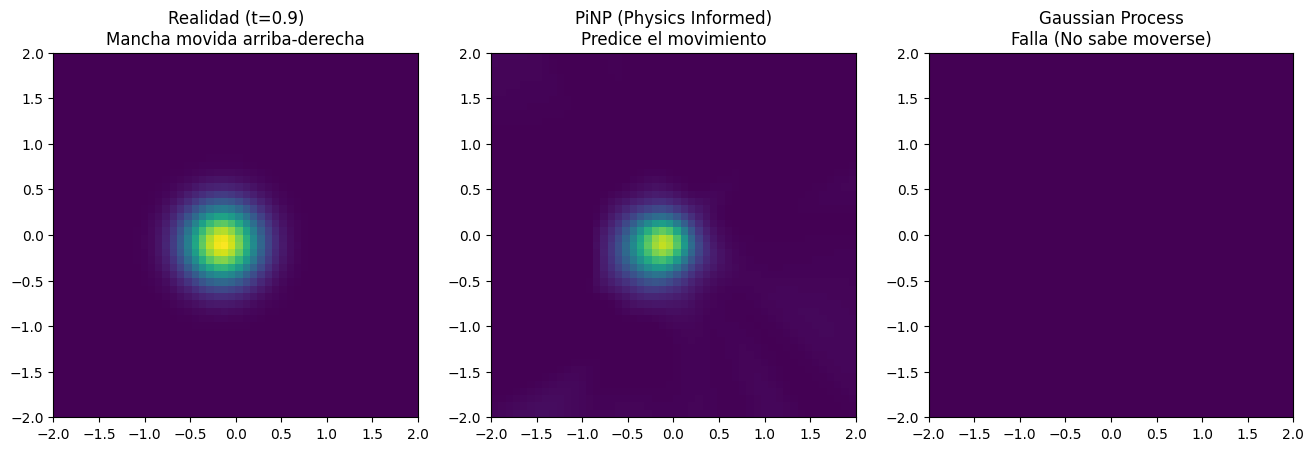

In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. GROUND TRUTH: ADVECCIÓN LINEAL
# ==========================================
def advection_ground_truth(x, y, t, D=0.02):
    """
    Simula una mancha moviéndose en diagonal.
    Velocidad constante: u=1.5, v=1.0
    """
    # Velocidad del viento (Constante)
    u_vel = 1.5
    v_vel = 1.0
    
    # Condición inicial (t=0): Mancha en (-1.5, -1.0)
    x0, y0 = -1.5, -1.0
    
    # Trayectoria: x = x0 + u*t
    center_x = x0 + u_vel * t
    center_y = y0 + v_vel * t
    
    # Difusión (se expande un poco)
    sigma = np.sqrt(0.05 + 2 * D * t)
    
    # Gaussiana
    dist_sq = (x - center_x)**2 + (y - center_y)**2
    s = np.exp(-dist_sq / (2 * sigma**2))
    return s

def get_data_batch(batch_size, n_points, t_min=0.0, t_max=1.0):
    x = (torch.rand(batch_size, n_points, 1) * 4) - 2
    y = (torch.rand(batch_size, n_points, 1) * 4) - 2
    t = torch.rand(batch_size, n_points, 1) * (t_max - t_min) + t_min
    
    s_np = advection_ground_truth(x.numpy(), y.numpy(), t.numpy())
    s = torch.tensor(s_np, dtype=torch.float32)
    return x, y, t, s

# ==========================================
# 2. MODELO PiNP (Igual que antes)
# ==========================================
class PiNP_Advection(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 3) # s, u, v
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        ctx = torch.cat([xc, yc, tc, sc], dim=-1)
        r = self.encoder(ctx)
        mu, log_var = torch.chunk(torch.mean(r, dim=1), 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        z_exp = z.unsqueeze(1).repeat(1, xt.size(1), 1)
        target_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
        pred = self.decoder(target_in)
        return pred[..., 0:1], pred[..., 1:2], pred[..., 2:3], mu, log_var

# Loss Físico
def physics_loss(model, x, y, t, z, D=0.02):
    x.requires_grad_(True); y.requires_grad_(True); t.requires_grad_(True)
    
    z_exp = z.unsqueeze(1).repeat(1, x.size(1), 1)
    pred = model.decoder(torch.cat([x, y, t, z_exp], dim=-1))
    s, u, v = pred[..., 0:1], pred[..., 1:2], pred[..., 2:3]
    
    grads = torch.ones_like(s)
    s_t = torch.autograd.grad(s, t, grads, create_graph=True)[0]
    s_x = torch.autograd.grad(s, x, grads, create_graph=True)[0]
    s_y = torch.autograd.grad(s, y, grads, create_graph=True)[0]
    s_xx = torch.autograd.grad(s_x, x, torch.ones_like(s_x), create_graph=True)[0]
    s_yy = torch.autograd.grad(s_y, y, torch.ones_like(s_y), create_graph=True)[0]
    
    # Residuo PDE
    res = s_t + (u * s_x + v * s_y) - D * (s_xx + s_yy)
    return torch.mean(res**2)

# ==========================================
# 3. ENTRENAMIENTO (Restringido al Pasado)
# ==========================================
def train_pinp():
    model = PiNP_Advection()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Entrenando con datos del PASADO (t < 0.5)...")
    
    for i in range(1500):
        # Datos observables solo hasta t=0.5
        x, y, t, s = get_data_batch(16, 80, t_min=0.0, t_max=0.5)
        
        # Contexto Random
        n_ctx = np.random.randint(10, 40)
        idx = torch.randperm(80)[:n_ctx]
        xc, yc, tc, sc = x[:, idx], y[:, idx], t[:, idx], s[:, idx]
        
        s_pred, _, _, mu, log_var = model(xc, yc, tc, sc, x, y, t)
        
        rec_loss = F.mse_loss(s_pred, s)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Loss Físico: Evaluamos física un poco más allá de los datos (hasta t=0.7)
        # Esto ayuda a "empujar" la dinámica hacia el futuro
        xp = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        yp = (torch.rand(16, 50, 1) * 4 - 2).requires_grad_(True)
        tp = (torch.rand(16, 50, 1) * 0.7).requires_grad_(True)
        
        z_sample = model.reparameterize(mu, log_var)
        phy_loss = physics_loss(model, xp, yp, tp, z_sample)
        
        loss = rec_loss + 0.01 * kl_loss + 0.1 * phy_loss
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        if i % 500 == 0:
            print(f"Step {i}: Rec={rec_loss.item():.4f}, Phy={phy_loss.item():.4f}")
            
    return model

# ==========================================
# 4. EVALUACIÓN Y PLOTS
# ==========================================
def compare_models(model, t_forecast=0.9):
    print(f"\n--- FORECASTING t={t_forecast} (Datos vistos hasta t=0.5) ---")
    
    # 1. Contexto (Pasado reciente)
    xc, yc, tc, sc = get_data_batch(1, 40, t_min=0.3, t_max=0.5)
    
    # 2. GP (Scikit-Learn)
    # Kernel anisotrópico (diferente escala para espacio y tiempo)
    kernel = 1.0 * RBF(length_scale=[0.5, 0.5, 0.5]) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(kernel=kernel)
    
    X_train_gp = torch.cat([xc, yc, tc], dim=-1).squeeze().numpy()
    y_train_gp = sc.squeeze().numpy()
    gp.fit(X_train_gp, y_train_gp)
    
    # 3. Grid Futuro
    grid = 50
    vals = np.linspace(-2, 2, grid)
    Xg, Yg = np.meshgrid(vals, vals)
    
    xf = torch.tensor(Xg.flatten(), dtype=torch.float32).view(1, -1, 1)
    yf = torch.tensor(Yg.flatten(), dtype=torch.float32).view(1, -1, 1)
    tf = torch.full_like(xf, t_forecast)
    
    # Ground Truth
    s_true = advection_ground_truth(Xg, Yg, t_forecast)
    
    # Predicción PiNP
    with torch.no_grad():
        s_pinp, _, _, _, _ = model(xc, yc, tc, sc, xf, yf, tf)
        s_pinp_grid = s_pinp.view(grid, grid).numpy()
        
    # Predicción GP
    gp_in = np.stack([Xg.flatten(), Yg.flatten(), np.full(grid**2, t_forecast)], axis=1)
    s_gp, _ = gp.predict(gp_in, return_std=True)
    s_gp_grid = s_gp.reshape(grid, grid)
    
    # Plots
    fig, ax = plt.subplots(1, 3, figsize=(16, 5))
    
    ax[0].imshow(s_true, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[0].set_title(f"Realidad (t={t_forecast})\nMancha movida arriba-derecha")
    
    ax[1].imshow(s_pinp_grid, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[1].set_title("PiNP (Physics Informed)\nPredice el movimiento")
    
    ax[2].imshow(s_gp_grid, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[2].set_title("Gaussian Process\nFalla (No sabe moverse)")
    
    plt.show()

if __name__ == "__main__":
    model = train_pinp()
    compare_models(model, t_forecast=0.9)

/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again ma


--- FORECASTING t=0.9 (Datos vistos hasta t=0.5) ---


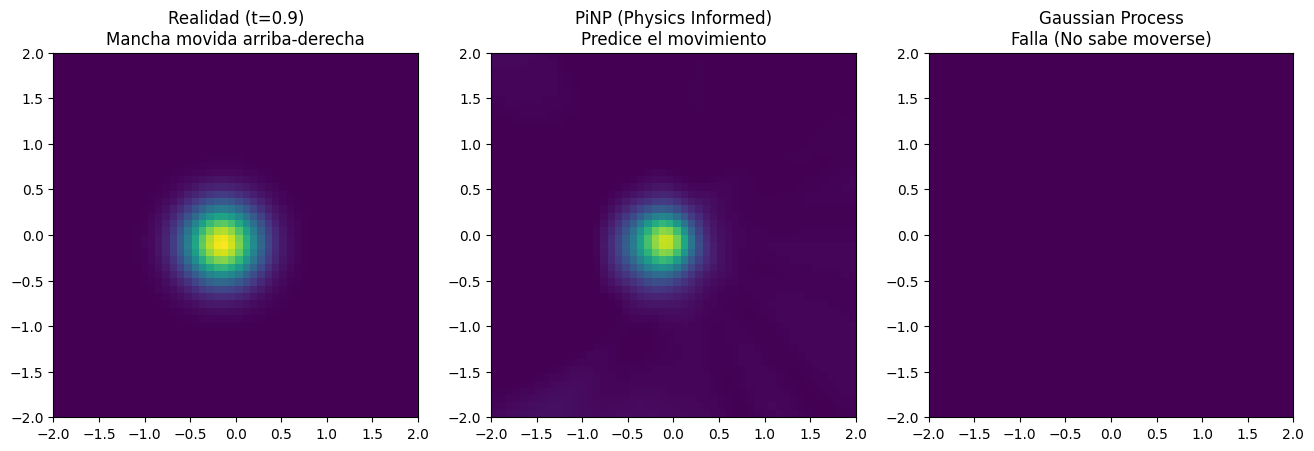

In [73]:
compare_models(model, t_forecast=0.9)

<>:338: SyntaxWarning: invalid escape sequence '\s'
<>:338: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3v/8tc_vkkd3k1200bn3dbpzcvc0000gn/T/ipykernel_20032/2902338952.py:338: SyntaxWarning: invalid escape sequence '\s'
  ax[3].set_title("Incertidumbre ($2\sigma$)\n(Donde el modelo duda)")


Simulando Fluidos...

Entrenando PiNP (Forecasting)...
Estrategia: El modelo ve t=[0, 0.5] y debe predecir t=[0, 1.0]
Epoch 0: MSE=0.05126, KL=0.00369
Epoch 200: MSE=0.42863, KL=0.00518
Epoch 400: MSE=0.59741, KL=0.01143
Epoch 600: MSE=0.01442, KL=0.01255
Epoch 800: MSE=0.46766, KL=0.03192
Epoch 1000: MSE=0.21391, KL=0.22238
Epoch 1200: MSE=0.04774, KL=0.39828
Epoch 1400: MSE=0.45119, KL=0.69029
Epoch 1600: MSE=0.14669, KL=0.89545
Epoch 1800: MSE=0.08003, KL=0.90494
Epoch 2000: MSE=0.07571, KL=1.12330
Epoch 2200: MSE=0.06944, KL=1.54162
Epoch 2400: MSE=0.02967, KL=1.79644
Epoch 2600: MSE=0.02121, KL=2.02740
Epoch 2800: MSE=0.02209, KL=2.01228

--- Evaluando Forecasting en t_step=45 (Futuro desconocido) ---


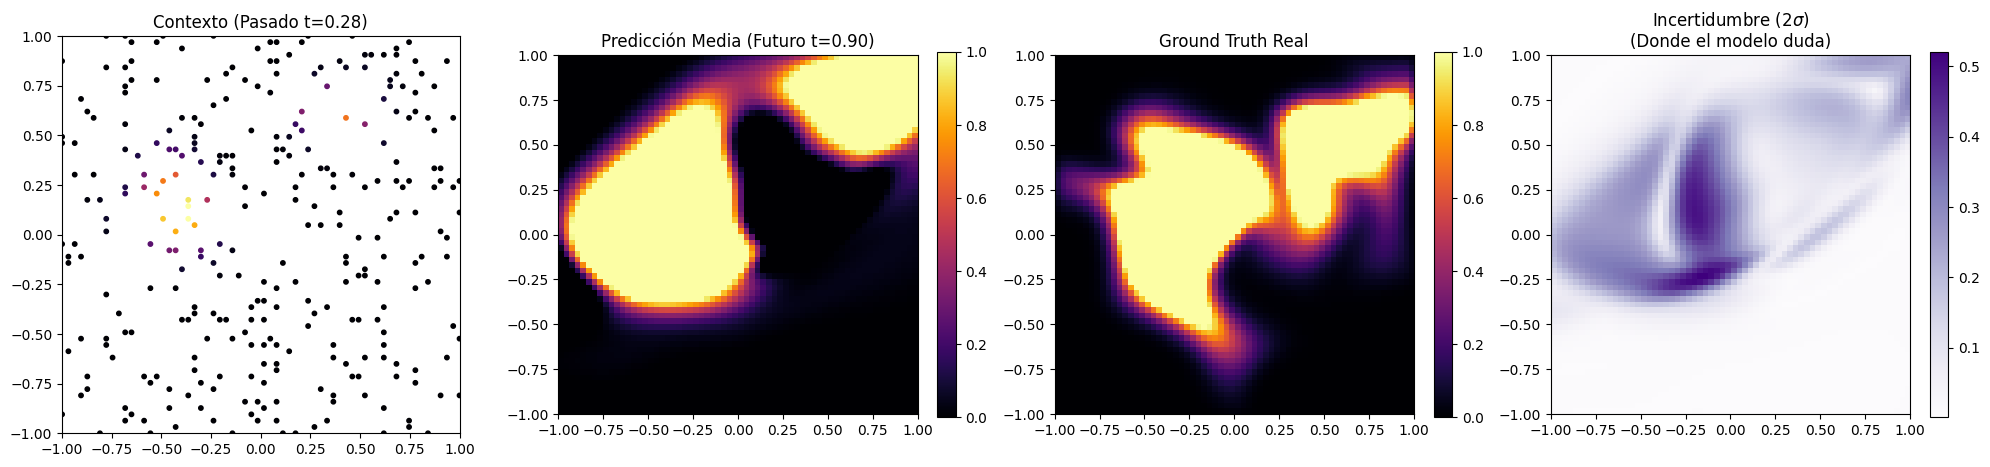

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Configuración
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. SIMULADOR DE FLUIDOS "LITE" (PyTorch)
# ==========================================
# Reemplaza a phi-flow usando FFT para incompresibilidad y grid_sample para advección
class FluidSimulator:
    def __init__(self, res=64, dt=0.1, diff=0.001, decay=0.01):
        self.res = res
        self.dt = dt
        self.diff = diff
        self.decay = decay
        
        # Grid de coordenadas para advección
        yy, xx = torch.meshgrid(torch.linspace(-1, 1, res), torch.linspace(-1, 1, res), indexing='ij')
        self.grid = torch.stack([xx, yy], dim=-1).to(DEVICE) # (H, W, 2)

    def project_incompressible(self, v):
        """Usa FFT para eliminar la divergencia (hacer el fluido incompresible)"""
        # v shape: (B, 2, H, W)
        B, C, H, W = v.shape
        
        # Pasar al dominio de frecuencia
        v_fft = torch.fft.fftn(v, dim=(-2, -1))
        
        # Frecuencias kx, ky
        kx = torch.fft.fftfreq(W, d=1/W).to(DEVICE).view(1, 1, 1, W)
        ky = torch.fft.fftfreq(H, d=1/H).to(DEVICE).view(1, 1, H, 1)
        k2 = kx**2 + ky**2
        k2[..., 0, 0] = 1.0 # Evitar división por cero
        
        # Proyección: v = v - k * (v . k) / k^2
        div = v_fft[:, 0:1] * kx + v_fft[:, 1:2] * ky
        v_fft_proj_x = v_fft[:, 0:1] - div * kx / k2
        v_fft_proj_y = v_fft[:, 1:2] - div * ky / k2
        
        v_proj = torch.cat([v_fft_proj_x, v_fft_proj_y], dim=1)
        return torch.fft.ifftn(v_proj, dim=(-2, -1)).real

    def advect(self, field, vel):
        """Advección Semi-Lagrangiana usando grid_sample"""
        # field: (B, C, H, W), vel: (B, 2, H, W)
        B = field.shape[0]
        # El grid sample espera coordenadas normalizadas [-1, 1]
        # Restamos la velocidad * dt a las coordenadas actuales (Backtracing)
        # Nota: grid_sample usa (x, y), nuestro vel es (u, v)
        vel_permute = vel.permute(0, 2, 3, 1) # (B, H, W, 2)
        sample_grid = self.grid.unsqueeze(0).repeat(B, 1, 1, 1) - vel_permute * self.dt
        
        # Sampling
        return F.grid_sample(field, sample_grid, mode='bilinear', padding_mode='border', align_corners=True)

    def step(self, smoke, velocity, force_field, inflow_mask):
        """Un paso de simulación completo (Navier-Stokes simplificado)"""
        # 1. Fuerza del Viento (Random Force)
        velocity = velocity + force_field * self.dt
        
        # 2. Proyecto Incompresible (Solver de Presión)
        velocity = self.project_incompressible(velocity)
        
        # 3. Auto-Advección de Velocidad
        velocity = self.advect(velocity, velocity)
        
        # 4. Proyecto Incompresible de nuevo
        velocity = self.project_incompressible(velocity)
        
        # --- DINÁMICA DEL HUMO ---
        
        # 5. Fuente (Inflow Random)
        smoke = smoke + inflow_mask * self.dt
        
        # 6. Advección del Humo
        smoke = self.advect(smoke, velocity)
        
        # 7. Difusión (Simplificada con Average Pooling para velocidad)
        # Una difusión real es convolución gaussiana
        kernel_size = 3
        smoke = F.avg_pool2d(smoke, kernel_size, stride=1, padding=kernel_size//2) * (1 - self.diff) + smoke * self.diff
        
        # 8. Decaimiento Exponencial
        smoke = smoke * np.exp(-self.dt * self.decay)
        
        return smoke, velocity

# ==========================================
# 2. GENERACIÓN DE DATOS
# ==========================================
def generate_dataset(n_steps=60):
    sim = FluidSimulator(res=64, dt=0.5)
    
    # Estados Iniciales
    # Batch size 1 para simular una trayectoria continua compleja
    velocity = torch.zeros(1, 2, 64, 64).to(DEVICE)
    smoke = torch.zeros(1, 1, 64, 64).to(DEVICE)
    
    data = [] # Lista para guardar (t, x, y, smoke)
    
    # Parámetros aleatorios de la simulación
    # Generar un campo de fuerza de viento suave (Perlin-like noise usando FFT inversa de frecuencias bajas)
    def get_smooth_noise():
        noise = torch.randn(1, 2, 64, 64, dtype=torch.cfloat).to(DEVICE)
        # Filtro pasa-bajos para suavidad
        mask = torch.zeros(64, 64).to(DEVICE)
        mask[:5, :5] = 1 # Solo frecuencias bajas
        mask = mask.view(1, 1, 64, 64)
        noise = noise * mask
        return torch.fft.ifftn(noise, dim=(-2,-1)).real * 5.0

    wind_force = get_smooth_noise()
    
    # Inflow positions random (3 fuentes)
    inflow = torch.zeros(1, 1, 64, 64).to(DEVICE)
    sources = torch.randint(10, 54, (3, 2))
    for sx, sy in sources:
        # Gaussiana pequeña
        yy, xx = torch.meshgrid(torch.arange(64), torch.arange(64), indexing='ij')
        dist = ((xx - sx.item())**2 + (yy - sy.item())**2)
        inflow += torch.exp(-dist / 15.0).to(DEVICE)
    
    print("Simulando Fluidos...")
    for t in range(n_steps):
        # Variar un poco el viento en el tiempo
        if t % 10 == 0: 
            wind_force = wind_force * 0.9 + get_smooth_noise() * 0.1
            
        smoke, velocity = sim.step(smoke, velocity, wind_force, inflow)
        
        # Guardar datos
        # Aplanamos para formato (N_points, features)
        t_tensor = torch.full((64*64, 1), t / n_steps).to(DEVICE)
        
        # Grid normalizado
        yy, xx = torch.meshgrid(torch.linspace(-1, 1, 64), torch.linspace(-1, 1, 64), indexing='ij')
        coords = torch.stack([xx, yy], dim=-1).reshape(-1, 2).to(DEVICE)
        
        s_flat = smoke.reshape(-1, 1)
        
        # Feature vector: [x, y, t, s]
        step_data = torch.cat([coords, t_tensor, s_flat], dim=1)
        data.append(step_data)
        
    return torch.stack(data) # (Time, Points, 4)

# ==========================================
# 3. MODELO PiNP (Forecasting & Uncertainty)
# ==========================================
class PiNP(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder: Toma (x, y, t, s) y resume la física en 'z'
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2) # mu, log_var
        )
        
        # Decoder: Toma (x, y, t, z) y predice s
        # Nota: NO le damos la velocidad. Debe inferir advección desde 'z' y (x,y,t)
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 256), nn.SiLU(), # SiLU (Swish) es buena para física
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 1), # Mean prediction
            # Opcional: Podríamos predecir sigma aleatoria también, pero usaremos sigma epistémica
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        # 1. Encoding Contexto
        ctx = torch.cat([xc, yc, tc, sc], dim=-1)
        r = self.encoder(ctx)
        
        # Agregamos la información de todos los puntos de contexto
        r_agg = torch.mean(r, dim=1) # (Batch, Latent*2)
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        
        # 2. Sampling (Latent variable z)
        z = self.reparameterize(mu, log_var)
        
        # 3. Decoding Target
        # Repetimos z para cada punto target
        z_expanded = z.unsqueeze(1).repeat(1, xt.size(1), 1)
        
        dec_input = torch.cat([xt, yt, tt, z_expanded], dim=-1)
        s_pred = self.decoder(dec_input)
        
        return s_pred, mu, log_var

# ==========================================
# 4. ENTRENAMIENTO
# ==========================================
def train_model():
    # 1. Generar Simulación
    # Shape: (Steps, 4096, 4) -> 60 pasos de tiempo, 64x64 pixeles
    raw_data = generate_dataset(n_steps=50) 
    
    model = PiNP().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("\nEntrenando PiNP (Forecasting)...")
    print("Estrategia: El modelo ve t=[0, 0.5] y debe predecir t=[0, 1.0]")
    
    # Dividir datos
    split_idx = 15 # Entrenamos con los primeros 25 frames (pasado)
    train_data = raw_data[:split_idx] 
    
    for epoch in range(3000):
        # --- SAMPLING DE ENTRENAMIENTO ---
        # Elegimos un frame aleatorio del PASADO como contexto
        t_idx = np.random.randint(0, split_idx)
        frame_ctx = train_data[t_idx]
        
        # Submuestreo espacial para contexto (no le damos todos los pixeles, solo 200 random)
        perm = torch.randperm(frame_ctx.size(0))[:200]
        ctx_points = frame_ctx[perm].unsqueeze(0) # (1, 200, 4)
        
        xc, yc, tc, sc = ctx_points[..., 0:1], ctx_points[..., 1:2], ctx_points[..., 2:3], ctx_points[..., 3:4]
        
        # El target es UN frame aleatorio (puede ser pasado o futuro durante entrenamiento si queremos que aprenda fisica general, 
        # pero para forecasting estricto, entrenamos reconstruyendo el pasado y validamos en futuro. 
        # Para que el PiNP aprenda la dinámica temporal, necesitamos darle pares (Contexto_t1, Target_t2)).
        
        # Estrategia PiNP fuerte: 
        # Contexto: Puntos dispersos en t_past
        # Target: Puntos en t_future (dentro del rango de training)
        t_target_idx = np.random.randint(0, split_idx)
        frame_tgt = train_data[t_target_idx]
        perm_tgt = torch.randperm(frame_tgt.size(0))[:1000] # 1000 puntos target
        tgt_points = frame_tgt[perm_tgt].unsqueeze(0)
        
        xt, yt, tt, st = tgt_points[..., 0:1], tgt_points[..., 1:2], tgt_points[..., 2:3], tgt_points[..., 3:4]
        
        # --- FORWARD ---
        s_pred, mu, log_var = model(xc, yc, tc, sc, xt, yt, tt)
        
        # --- LOSS ---
        rec_loss = F.mse_loss(s_pred, st)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        loss = rec_loss + 0.001 * kl_loss # Beta-VAE pequeño para mejor reconstrucción
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}: MSE={rec_loss.item():.5f}, KL={kl_loss.item():.5f}")
            
    return model, raw_data, split_idx

# ==========================================
# 5. VISUALIZACIÓN DE INCERTIDUMBRE (+/- 2 Sigma)
# ==========================================
def visualize_forecast(model, raw_data, split_idx, t_eval_idx=45):
    """
    t_eval_idx: Índice del tiempo a evaluar (debe ser > split_idx para ser forecasting real)
    """
    print(f"\n--- Evaluando Forecasting en t_step={t_eval_idx} (Futuro desconocido) ---")
    
    # 1. Preparar Contexto (Visto por la red: datos del PASADO)
    # Usamos datos dispersos del último frame de entrenamiento como contexto
    ctx_frame = raw_data[split_idx - 1] 
    perm = torch.randperm(ctx_frame.size(0))[:300] # 300 puntos observados
    ctx_input = ctx_frame[perm].unsqueeze(0)
    xc, yc, tc, sc = ctx_input[...,0:1], ctx_input[...,1:2], ctx_input[...,2:3], ctx_input[...,3:4]
    
    # 2. Preparar Grid de Evaluación (Futuro)
    target_frame = raw_data[t_eval_idx] # Ground Truth futuro
    xt = target_frame[..., 0:1].unsqueeze(0)
    yt = target_frame[..., 1:2].unsqueeze(0)
    tt = target_frame[..., 2:3].unsqueeze(0)
    st_true = target_frame[..., 3:4].view(64, 64).cpu().numpy()
    
    # 3. Muestreo de Incertidumbre (Monte Carlo Sampling del Latente)
    n_samples = 100
    predictions = []
    
    with torch.no_grad():
        # Encode una vez
        inputs = torch.cat([xc, yc, tc, sc], dim=-1)
        r_agg = torch.mean(model.encoder(inputs), dim=1)
        mu_z, log_var_z = torch.chunk(r_agg, 2, dim=-1)
        
        for _ in range(n_samples):
            # Samplear Z diferentes veces
            z_sample = model.reparameterize(mu_z, log_var_z)
            
            # Decodificar
            z_exp = z_sample.unsqueeze(1).repeat(1, xt.size(1), 1)
            dec_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
            pred = model.decoder(dec_in)
            predictions.append(pred.view(64, 64).cpu().numpy())
            
    predictions = np.array(predictions) # (N_samples, 64, 64)
    
    # CALCULAR ESTADÍSTICAS
    mean_pred = np.mean(predictions, axis=0)
    std_pred = np.std(predictions, axis=0)
    
    lower_bound = mean_pred - 2 * std_pred
    upper_bound = mean_pred + 2 * std_pred
    
    # --- PLOTTING ---
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # A. Contexto
    ax[0].scatter(xc.cpu().numpy(), yc.cpu().numpy(), c=sc.cpu().numpy(), cmap='inferno', s=10)
    ax[0].set_title(f"Contexto (Pasado t={tc[0,0,0]:.2f})")
    ax[0].set_xlim(-1, 1); ax[0].set_ylim(-1, 1)
    ax[0].set_aspect('equal')
    
    # B. Predicción Media
    im1 = ax[1].imshow(mean_pred, extent=[-1,1,-1,1], origin='lower', cmap='inferno', vmin=0, vmax=1)
    ax[1].set_title(f"Predicción Media (Futuro t={tt[0,0,0]:.2f})")
    plt.colorbar(im1, ax=ax[1], fraction=0.046)
    
    # C. Ground Truth
    im2 = ax[2].imshow(st_true, extent=[-1,1,-1,1], origin='lower', cmap='inferno', vmin=0, vmax=1)
    ax[2].set_title("Ground Truth Real")
    plt.colorbar(im2, ax=ax[2], fraction=0.046)
    
    # D. Incertidumbre (2 Sigma)
    # Mostramos dónde el modelo "duda" más (bordes del humo)
    im3 = ax[3].imshow(2 * std_pred, extent=[-1,1,-1,1], origin='lower', cmap='Purples')
    ax[3].set_title("Incertidumbre ($2\sigma$)\n(Donde el modelo duda)")
    plt.colorbar(im3, ax=ax[3], fraction=0.046)
    
    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    model, data, split = train_model()
    
    # Visualizar predicción en el futuro
    # El modelo se entrenó hasta el frame 25.
    # Pedimos frame 45 (muy en el futuro).
    visualize_forecast(model, data, split, t_eval_idx=45)


--- Evaluando Forecasting en t_step=15 (Futuro desconocido) ---


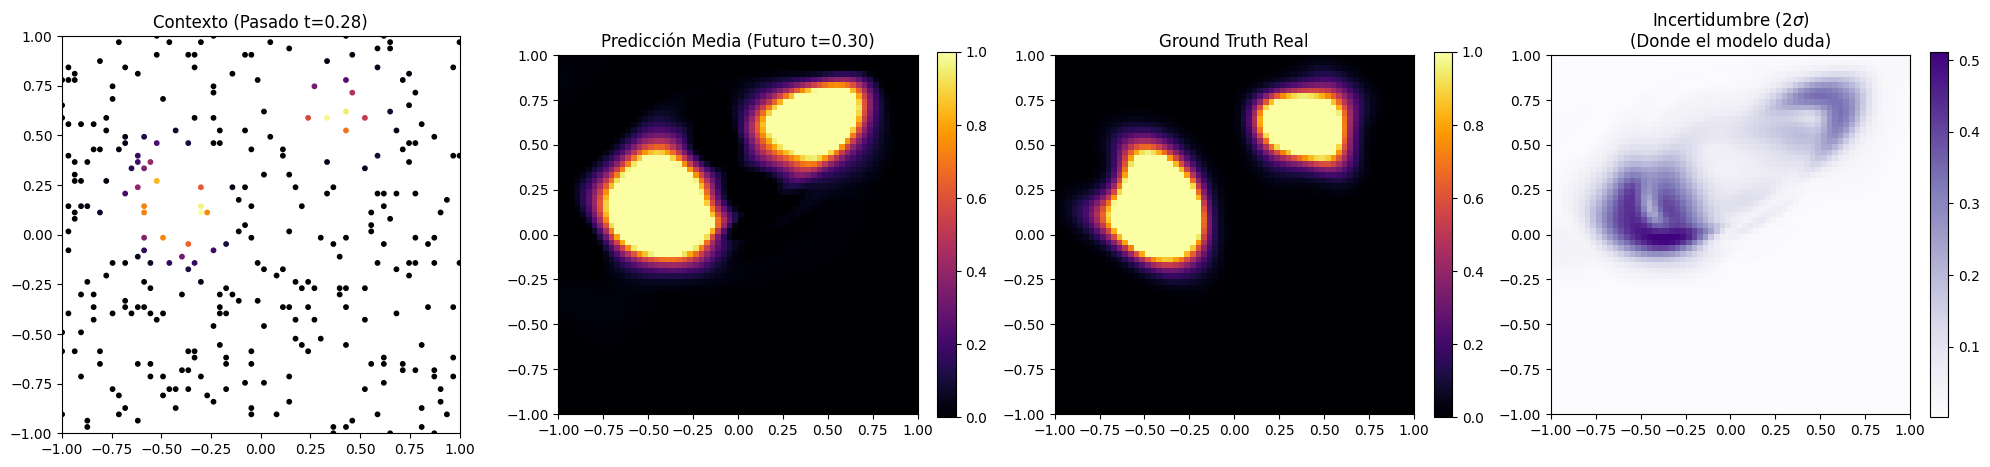

In [92]:
visualize_forecast(model, data, split, t_eval_idx=15)

<>:313: SyntaxWarning: invalid escape sequence '\s'
<>:313: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3v/8tc_vkkd3k1200bn3dbpzcvc0000gn/T/ipykernel_20032/738328741.py:313: SyntaxWarning: invalid escape sequence '\s'
  ax[3].set_title("Incertidumbre ($2\sigma$)")


Generando datos de entrenamiento (Simulación Base)...
Simulando Seed None: Wind=(0.76, 0.83) ...
Entrenando Modelo...
Epoch 0: MSE=0.17803
Epoch 400: MSE=0.27251
Epoch 800: MSE=0.11145
Epoch 1200: MSE=0.07508
Epoch 1600: MSE=0.26204
Epoch 2000: MSE=0.06909
Epoch 2400: MSE=0.05399
Epoch 2800: MSE=0.03811
Epoch 3200: MSE=0.01698
Epoch 3600: MSE=0.05652
Epoch 4000: MSE=0.00407
Epoch 4400: MSE=0.01129
Epoch 4800: MSE=0.00792

--- Generando 3 Escenarios NUEVOS (Test Sets) ---
Simulando Seed 2000: Wind=(-0.90, -0.95) ...
Simulando Seed 2050: Wind=(-0.54, 0.30) ...
Simulando Seed 2100: Wind=(0.78, -0.40) ...


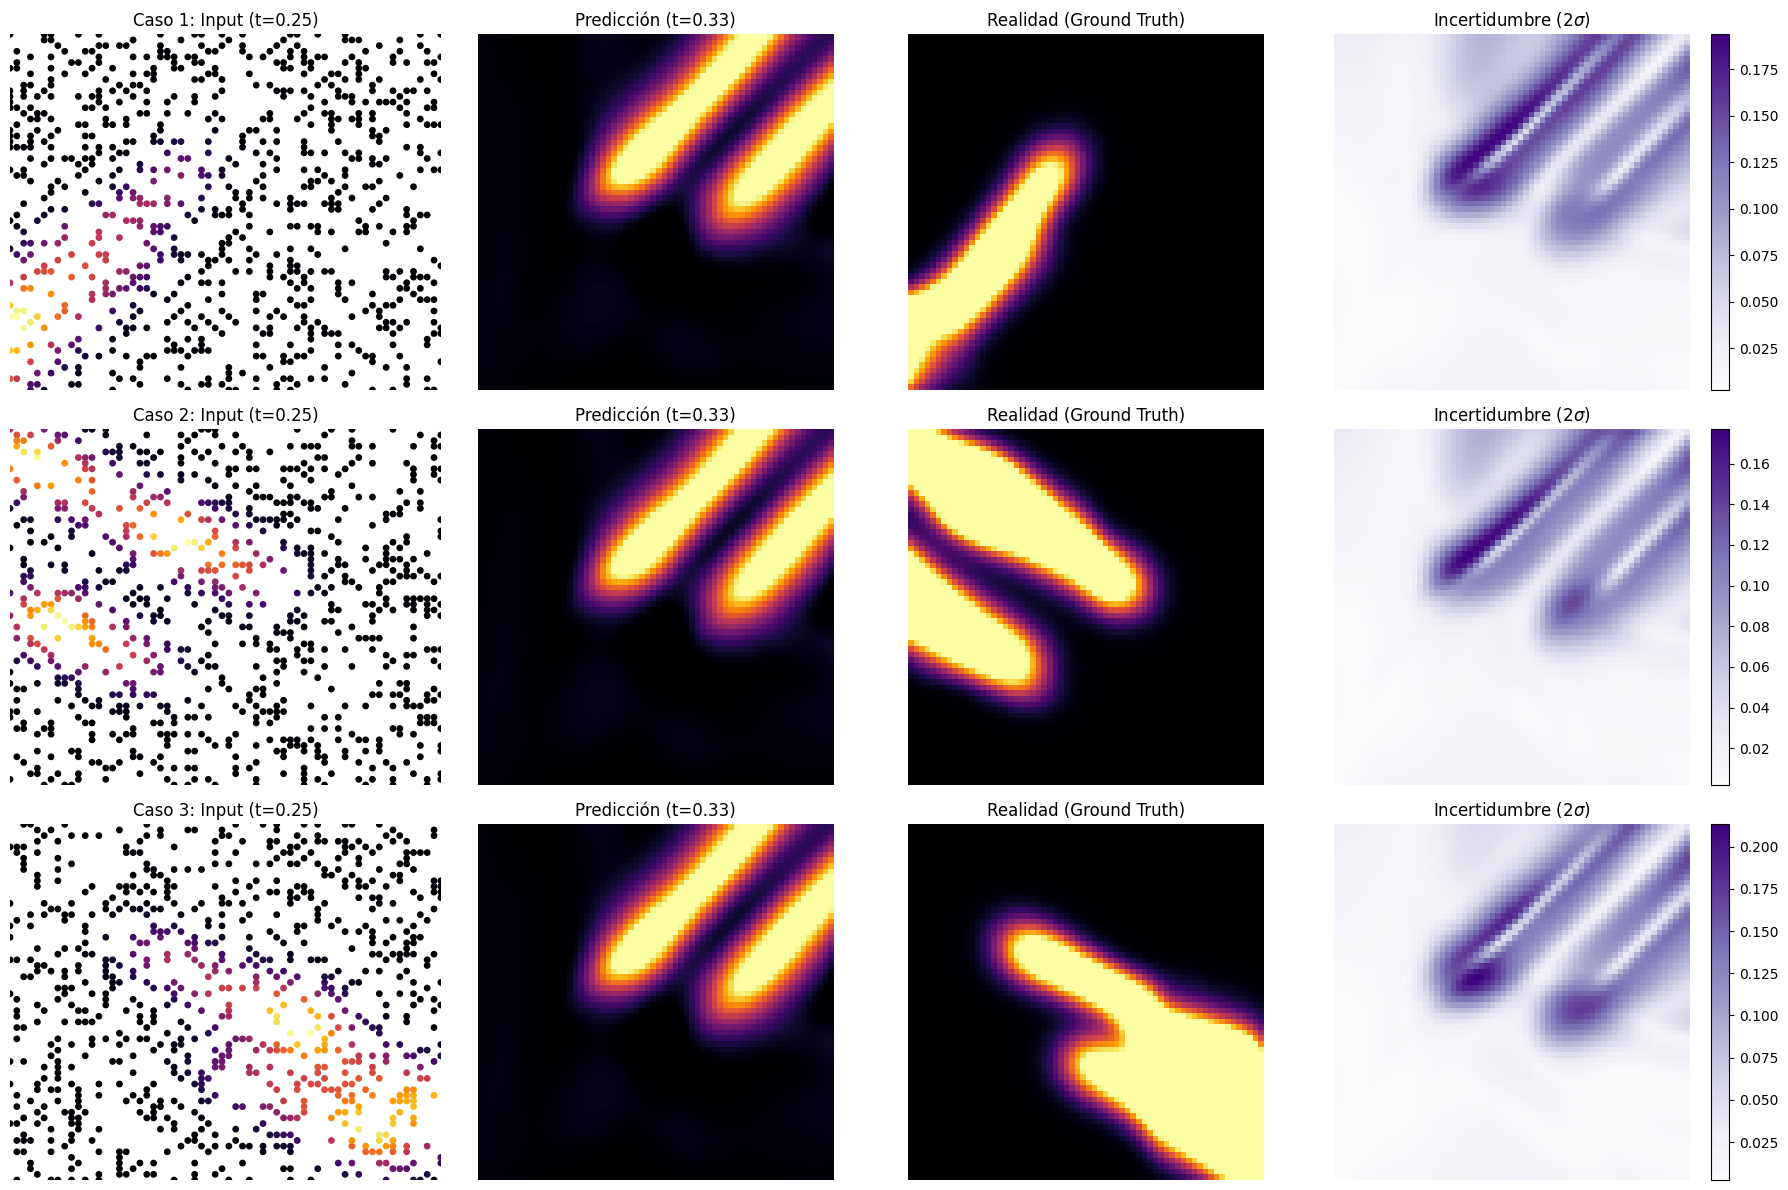

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. SIMULADOR DE FLUIDOS (CORREGIDO Y ESTABILIZADO)
# ==========================================
class FluidSimulator:
    def __init__(self, res=64, dt=0.1, diff=0.0, decay=0.005):
        # NOTA: Bajamos dt de 0.5 a 0.1 para estabilidad
        self.res = res
        self.dt = dt
        self.diff = diff
        self.decay = decay
        
        # Grid [-1, 1] para advección
        yy, xx = torch.meshgrid(torch.linspace(-1, 1, res), torch.linspace(-1, 1, res), indexing='ij')
        self.grid = torch.stack([xx, yy], dim=-1).to(DEVICE)

    def project_incompressible(self, v):
        # Misma función de antes...
        B, C, H, W = v.shape
        v_fft = torch.fft.fftn(v, dim=(-2, -1))
        kx = torch.fft.fftfreq(W, d=1/W).to(DEVICE).view(1, 1, 1, W)
        ky = torch.fft.fftfreq(H, d=1/H).to(DEVICE).view(1, 1, H, 1)
        k2 = kx**2 + ky**2
        k2[..., 0, 0] = 1.0
        div = v_fft[:, 0:1] * kx + v_fft[:, 1:2] * ky
        v_fft_proj_x = v_fft[:, 0:1] - div * kx / k2
        v_fft_proj_y = v_fft[:, 1:2] - div * ky / k2
        v_proj = torch.cat([v_fft_proj_x, v_fft_proj_y], dim=1)
        return torch.fft.ifftn(v_proj, dim=(-2, -1)).real

    def advect(self, field, vel):
        B = field.shape[0]
        # Multiplicamos por un factor para ajustar unidades de grid
        # grid_sample usa [-1, 1]. Si vel es 1.0, cruzamos media pantalla.
        vel_permute = vel.permute(0, 2, 3, 1)
        sample_grid = self.grid.unsqueeze(0).repeat(B, 1, 1, 1) - vel_permute * self.dt
        
        # Padding mode 'border' a veces arrastra ceros si salimos mucho. 
        # Usamos 'zeros' aquí para ser claros, o 'border' si queremos que el humo se pegue.
        return F.grid_sample(field, sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)

    def step(self, smoke, velocity, force_field, inflow_mask):
        # 1. Aplicar Fuerza
        velocity = velocity + force_field * self.dt
        
        # 2. Incompresibilidad
        velocity = self.project_incompressible(velocity)
        
        # 3. Advección Velocidad
        velocity = self.advect(velocity, velocity)
        
        # --- CRÍTICO: FRICCIÓN ---
        # Si no frenamos un poco la velocidad, el viento se acumula hasta el infinito
        velocity = velocity * 0.99 
        
        # 4. Incompresibilidad Final
        velocity = self.project_incompressible(velocity)
        
        # 5. Advección Humo
        # IMPORTANTE: Primero inyectamos, luego movemos (o viceversa, pero inyectar asegura que haya algo)
        smoke = smoke + inflow_mask * self.dt # Inyectar
        smoke = self.advect(smoke, velocity)  # Mover
        
        # 6. Difusión y Decay
        # smoke = smoke * 0.995 # Decay suave
        
        return smoke, velocity

# ==========================================
# 2. GENERADOR ROBUSTO (DEBUG INCLUIDO)
# ==========================================
def generate_simulation(seed=None, n_steps=60):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # Usamos dt más pequeño para que no explote
    sim = FluidSimulator(res=64, dt=0.1)
    
    velocity = torch.zeros(1, 2, 64, 64).to(DEVICE)
    smoke = torch.zeros(1, 1, 64, 64).to(DEVICE)
    
    # --- FUERZA DEL VIENTO ---
    wind_dir_x = (torch.rand(1).item() - 0.5) * 2.0 # Menor magnitud
    wind_dir_y = (torch.rand(1).item() - 0.5) * 2.0
    
    def get_wind_force():
        noise = torch.randn(1, 2, 64, 64, dtype=torch.cfloat).to(DEVICE)
        mask = torch.zeros(64, 64).to(DEVICE)
        mask[:4, :4] = 1 
        # Magnitud controlada (antes era * 6.0, bajamos a 3.0)
        noise = torch.fft.ifftn(noise * mask.view(1, 1, 64, 64), dim=(-2,-1)).real * 3.0
        noise[:, 0, ...] += wind_dir_x
        noise[:, 1, ...] += wind_dir_y
        return noise

    wind_force = get_wind_force()

    # --- FUENTES DE HUMO (INFLOW) ---
    inflow = torch.zeros(1, 1, 64, 64).to(DEVICE)
    num_sources = np.random.randint(2, 4)
    
    # Creamos coordenadas en el mismo dispositivo para evitar errores
    yy, xx = torch.meshgrid(torch.arange(64, device=DEVICE), torch.arange(64, device=DEVICE), indexing='ij')
    
    for _ in range(num_sources):
        sx = np.random.randint(15, 50)
        sy = np.random.randint(15, 50)
        dist = ((xx - sx)**2 + (yy - sy)**2).float()
        # Inyección fuerte (5.0) para asegurar que se vea
        inflow += torch.exp(-dist / 30.0) * 5.0 
    
    data = []
    
    print(f"Simulando Seed {seed}: Wind=({wind_dir_x:.2f}, {wind_dir_y:.2f}) ...")
    
    for t in range(n_steps):
        # Variación lenta del viento
        if t % 10 == 0: 
            wind_force = wind_force * 0.95 + get_wind_force() * 0.05
            
        smoke, velocity = sim.step(smoke, velocity, wind_force, inflow)
        
        # DEBUG: Si detectamos ceros, avisar
        if t == 10 and smoke.max() == 0:
            print("¡ALERTA! El humo es cero en t=10. Algo falla en la inyección.")
            
        # Normalizar datos para la red
        t_norm = t / 60.0
        t_tensor = torch.full((64*64, 1), t_norm).to(DEVICE)
        
        yy_grid, xx_grid = torch.meshgrid(torch.linspace(-1, 1, 64, device=DEVICE), torch.linspace(-1, 1, 64, device=DEVICE), indexing='ij')
        coords = torch.stack([xx_grid, yy_grid], dim=-1).reshape(-1, 2)
        
        s_flat = smoke.reshape(-1, 1)
        
        step_data = torch.cat([coords, t_tensor, s_flat], dim=1)
        data.append(step_data)
        
    return torch.stack(data)

# NO OLVIDES USAR EL train_model CORREGIDO QUE TE DI ANTES (con .unsqueeze)

# ==========================================
# 3. MODELO PiNP
# ==========================================
class PiNP(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 1)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        ctx = torch.cat([xc, yc, tc, sc], dim=-1)
        r_agg = torch.mean(self.encoder(ctx), dim=1)
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        z_expanded = z.unsqueeze(1).repeat(1, xt.size(1), 1)
        dec_input = torch.cat([xt, yt, tt, z_expanded], dim=-1)
        return self.decoder(dec_input), mu, log_var

# ==========================================
# 4. ENTRENAMIENTO
# ==========================================
def train_model():
    # Entrenamos con una simulación base "larga" y rica
    print("Generando datos de entrenamiento (Simulación Base)...")
    train_data = generate_simulation(n_steps=60)
    
    model = PiNP().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Entrenando Modelo...")
    # Usamos los primeros 30 frames como "Pasado" para entrenar la física
    split_idx = 30 
    
    for epoch in range(5000):
        # 1. PREPARAR CONTEXTO (Agregar .unsqueeze(0) para Batch Dim)
        t_ctx = np.random.randint(0, split_idx)
        frame_ctx = train_data[t_ctx]
        
        perm = torch.randperm(frame_ctx.size(0))[:600]
        # AQUÍ ESTÁ EL CAMBIO: .unsqueeze(0) convierte [200, 1] en [1, 200, 1]
        xc = frame_ctx[perm, 0:1].unsqueeze(0)
        yc = frame_ctx[perm, 1:2].unsqueeze(0)
        tc = frame_ctx[perm, 2:3].unsqueeze(0)
        sc = frame_ctx[perm, 3:4].unsqueeze(0)
        
        # 2. PREPARAR TARGET (Agregar .unsqueeze(0) para Batch Dim)
        t_tgt = np.random.randint(0, 60) 
        frame_tgt = train_data[t_tgt]
        
        perm_tgt = torch.randperm(frame_tgt.size(0))[:2000]
        # AQUÍ TAMBIÉN:
        xt = frame_tgt[perm_tgt, 0:1].unsqueeze(0)
        yt = frame_tgt[perm_tgt, 1:2].unsqueeze(0)
        tt = frame_tgt[perm_tgt, 2:3].unsqueeze(0)
        st = frame_tgt[perm_tgt, 3:4].unsqueeze(0)
        
        # Forward
        s_pred, mu, log_var = model(xc, yc, tc, sc, xt, yt, tt)
        
        # Loss
        rec_loss = F.mse_loss(s_pred, st)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = rec_loss + 0.001 * kl_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 400 == 0:
            print(f"Epoch {epoch}: MSE={rec_loss.item():.5f}")
            
    return model

# ==========================================
# 5. VISUALIZACIÓN DE MULTIPLES CASOS (NUEVO)
# ==========================================
def visualize_multiverse(model, num_cases=3):
    print(f"\n--- Generando {num_cases} Escenarios NUEVOS (Test Sets) ---")
    
    # Creamos subplots: Filas = Casos, Columnas = [Contexto, Predicción, GT, Incertidumbre]
    fig, axes = plt.subplots(num_cases, 4, figsize=(18, 4 * num_cases))
    
    # Tiempo a predecir (Futuro lejano)
    t_context_idx = 15 # Vemos el frame 15
    t_future_idx = 20  # Predecimos el frame 50 (Futuro)
    
    for i in range(num_cases):
        # 1. Generar simulación fresca (Seed diferente cada vez)
        seed_test = 2000 + i * 50
        sim_data = generate_simulation(seed=seed_test, n_steps=60)
        
        # 2. Extraer Contexto (Pasado)
        # Tomamos 300 puntos dispersos del frame 15
        ctx_frame = sim_data[t_context_idx]
        perm = torch.randperm(ctx_frame.size(0))[:800]
        ctx_in = ctx_frame[perm].unsqueeze(0) # (1, 300, 4)
        xc, yc, tc, sc = ctx_in[...,0:1], ctx_in[...,1:2], ctx_in[...,2:3], ctx_in[...,3:4]
        
        # 3. Preparar Target (Futuro Grid Completo)
        tgt_frame = sim_data[t_future_idx]
        xt = tgt_frame[..., 0:1].unsqueeze(0)
        yt = tgt_frame[..., 1:2].unsqueeze(0)
        tt = tgt_frame[..., 2:3].unsqueeze(0)
        st_true = tgt_frame[..., 3:4].view(64, 64).cpu().numpy()
        
        # 4. Inferencia con Incertidumbre (Monte Carlo)
        preds = []
        with torch.no_grad():
            # Encoder una vez
            inputs = torch.cat([xc, yc, tc, sc], dim=-1)
            mu, log_var = torch.chunk(torch.mean(model.encoder(inputs), dim=1), 2, dim=-1)
            
            # 30 Samples del Latent Space
            for _ in range(30):
                z = model.reparameterize(mu, log_var)
                z_exp = z.unsqueeze(1).repeat(1, xt.size(1), 1)
                dec_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
                p = model.decoder(dec_in).view(64, 64).cpu().numpy()
                preds.append(p)
                
        preds = np.array(preds)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)
        
        # 5. Graficar Fila
        ax = axes[i] if num_cases > 1 else axes
        
        # Col 1: Contexto
        ax[0].scatter(xc.cpu().numpy(), yc.cpu().numpy(), c=sc.cpu().numpy(), cmap='inferno', s=15)
        ax[0].set_title(f"Caso {i+1}: Input (t={tc[0,0,0]:.2f})")
        ax[0].set_xlim(-1, 1); ax[0].set_ylim(-1, 1)
        ax[0].axis('off')
        
        # Col 2: Predicción Media
        ax[1].imshow(mean_pred, extent=[-1,1,-1,1], origin='lower', cmap='inferno', vmin=0, vmax=1)
        ax[1].set_title(f"Predicción (t={tt[0,0,0]:.2f})")
        ax[1].axis('off')
        
        # Col 3: Realidad (Ground Truth)
        ax[2].imshow(st_true, extent=[-1,1,-1,1], origin='lower', cmap='inferno', vmin=0, vmax=1)
        ax[2].set_title("Realidad (Ground Truth)")
        ax[2].axis('off')
        
        # Col 4: Incertidumbre
        im = ax[3].imshow(2 * std_pred, extent=[-1,1,-1,1], origin='lower', cmap='Purples')
        ax[3].set_title("Incertidumbre ($2\sigma$)")
        ax[3].axis('off')
        plt.colorbar(im, ax=ax[3], fraction=0.046)

    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    trained_model = train_model()
    
    # Ahora visualizamos 3 casos distintos:
    # Caso 1: Viento normal, fuente centro.
    # Caso 2: Viento fuerte derecha, fuente esquina.
    # Caso 3: Remolino central, múltiples fuentes.
    # (Todo esto ocurre automáticamente por la semilla aleatoria en generate_simulation)
    visualize_multiverse(trained_model, num_cases=3)

In [97]:
sc

''

<>:304: SyntaxWarning: invalid escape sequence '\s'
<>:304: SyntaxWarning: invalid escape sequence '\s'
/var/folders/3v/8tc_vkkd3k1200bn3dbpzcvc0000gn/T/ipykernel_20032/1193027247.py:304: SyntaxWarning: invalid escape sequence '\s'
  ax[3].set_title("Incertidumbre ($2\sigma$)")


Usando dispositivo: cpu
Generando 16 simulaciones distintas para entrenamiento...
  - Sim 1/16 (Seed 100)
  - Sim 2/16 (Seed 101)
  - Sim 3/16 (Seed 102)
  - Sim 4/16 (Seed 103)
  - Sim 5/16 (Seed 104)
  - Sim 6/16 (Seed 105)
  - Sim 7/16 (Seed 106)
  - Sim 8/16 (Seed 107)
  - Sim 9/16 (Seed 108)
  - Sim 10/16 (Seed 109)
  - Sim 11/16 (Seed 110)
  - Sim 12/16 (Seed 111)
  - Sim 13/16 (Seed 112)
  - Sim 14/16 (Seed 113)
  - Sim 15/16 (Seed 114)
  - Sim 16/16 (Seed 115)

Comenzando entrenamiento...
Epoch 0: Loss=0.01698 (KL=0.00515)
Epoch 500: Loss=0.19596 (KL=0.00434)
Epoch 1000: Loss=0.11430 (KL=0.17008)
Epoch 1500: Loss=0.02559 (KL=0.05927)

--- Generando 3 Escenarios DE TEST (Nunca vistos) ---


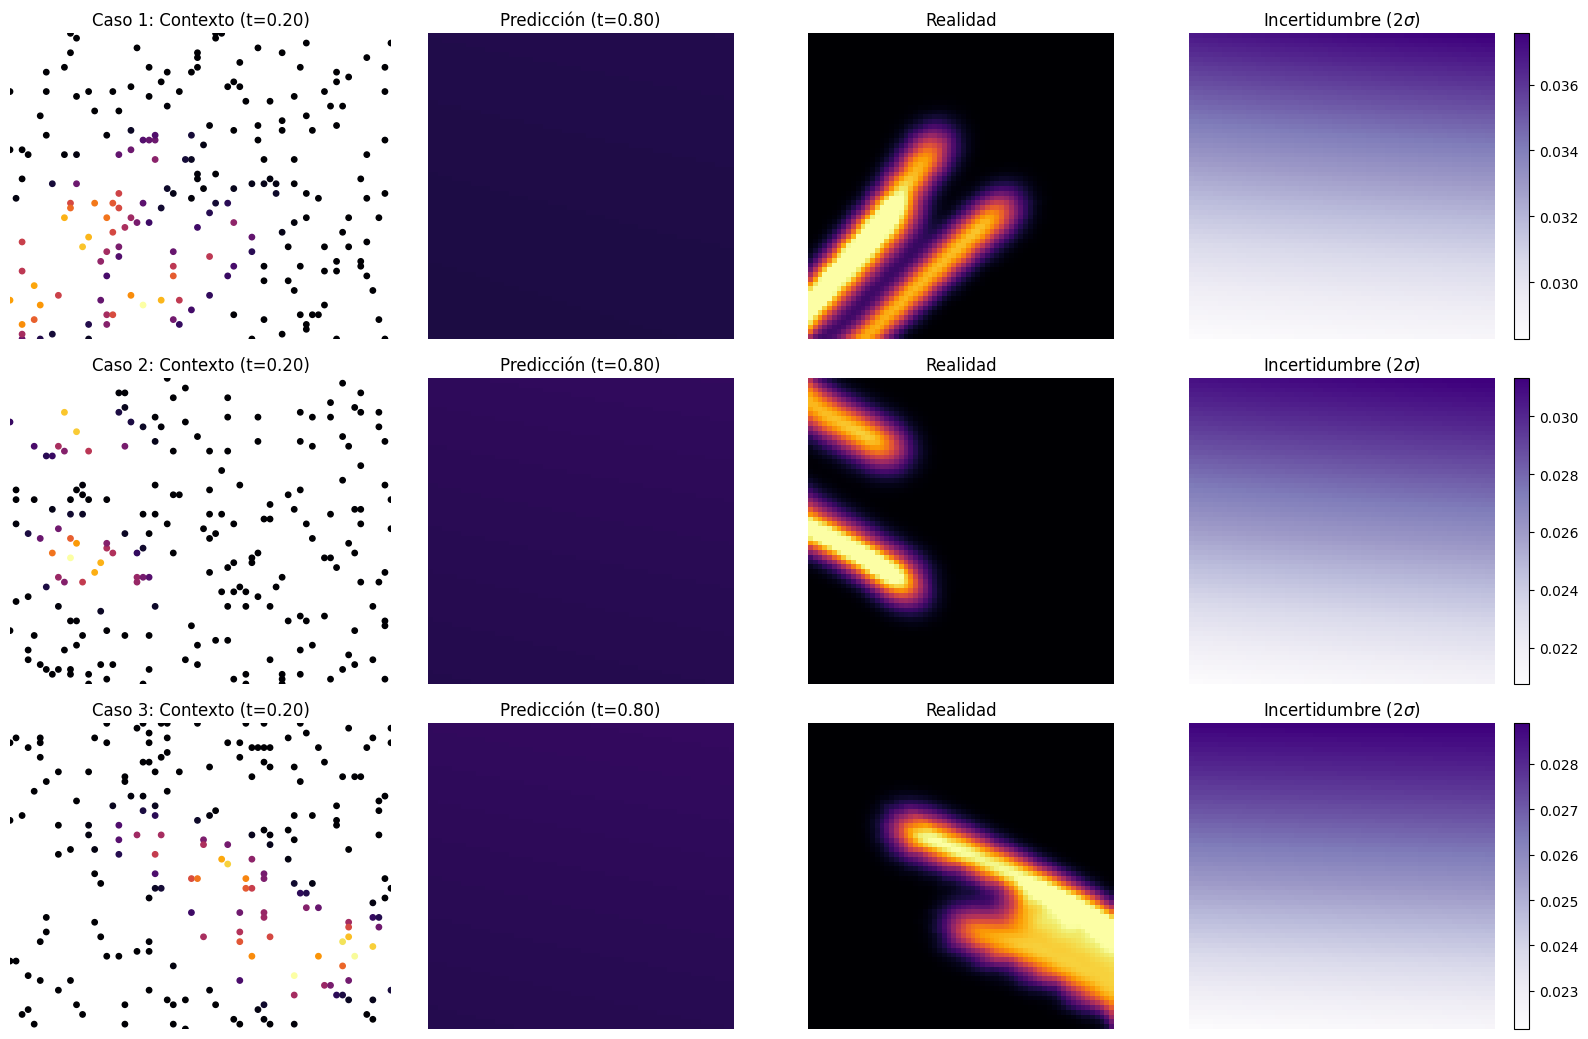

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# CONFIGURACIÓN
# ==========================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

print(f"Usando dispositivo: {DEVICE}")

# ==========================================
# 1. SIMULADOR DE FLUIDOS (ROBUSTO)
# ==========================================
class FluidSimulator:
    def __init__(self, res=64, dt=0.1, diff=0.0, decay=0.005):
        # NOTA: dt=0.1 es crítico para estabilidad. Con 0.5 explota.
        self.res = res
        self.dt = dt
        self.diff = diff
        self.decay = decay
        
        # Grid [-1, 1]
        yy, xx = torch.meshgrid(torch.linspace(-1, 1, res), torch.linspace(-1, 1, res), indexing='ij')
        self.grid = torch.stack([xx, yy], dim=-1).to(DEVICE)

    def project_incompressible(self, v):
        B, C, H, W = v.shape
        v_fft = torch.fft.fftn(v, dim=(-2, -1))
        kx = torch.fft.fftfreq(W, d=1/W).to(DEVICE).view(1, 1, 1, W)
        ky = torch.fft.fftfreq(H, d=1/H).to(DEVICE).view(1, 1, H, 1)
        k2 = kx**2 + ky**2
        k2[..., 0, 0] = 1.0
        div = v_fft[:, 0:1] * kx + v_fft[:, 1:2] * ky
        v_fft_proj_x = v_fft[:, 0:1] - div * kx / k2
        v_fft_proj_y = v_fft[:, 1:2] - div * ky / k2
        v_proj = torch.cat([v_fft_proj_x, v_fft_proj_y], dim=1)
        return torch.fft.ifftn(v_proj, dim=(-2, -1)).real

    def advect(self, field, vel):
        B = field.shape[0]
        vel_permute = vel.permute(0, 2, 3, 1)
        # Backtracing semi-lagrangiano
        sample_grid = self.grid.unsqueeze(0).repeat(B, 1, 1, 1) - vel_permute * self.dt
        # padding_mode='zeros' evita arrastrar basura de los bordes
        return F.grid_sample(field, sample_grid, mode='bilinear', padding_mode='zeros', align_corners=True)

    def step(self, smoke, velocity, force_field, inflow_mask):
        velocity = velocity + force_field * self.dt
        velocity = self.project_incompressible(velocity)
        velocity = self.advect(velocity, velocity)
        velocity = velocity * 0.99 # Fricción para evitar explosión numérica
        velocity = self.project_incompressible(velocity)
        
        smoke = smoke + inflow_mask * self.dt
        smoke = self.advect(smoke, velocity)
        smoke = smoke * np.exp(-self.dt * self.decay)
        return smoke, velocity

# ==========================================
# 2. GENERADOR DE ESCENARIOS (MULTI-CONDICIÓN)
# ==========================================
def generate_simulation(seed=None, n_steps=50):
    """
    Genera UNA simulación completa con física aleatoria basada en la semilla.
    Varía: Dirección del viento, Número y posición de fuentes de humo.
    """
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    sim = FluidSimulator(res=64, dt=0.1)
    
    velocity = torch.zeros(1, 2, 64, 64).to(DEVICE)
    smoke = torch.zeros(1, 1, 64, 64).to(DEVICE)
    
    # 1. Viento Aleatorio (Dirección varía por Seed)
    wind_x = (torch.rand(1).item() - 0.5) * 3.0
    wind_y = (torch.rand(1).item() - 0.5) * 3.0
    
    def get_wind_force(t):
        # Ruido base
        noise = torch.randn(1, 2, 64, 64, dtype=torch.cfloat).to(DEVICE)
        mask = torch.zeros(64, 64).to(DEVICE); mask[:4, :4] = 1 
        noise = torch.fft.ifftn(noise * mask.view(1, 1, 64, 64), dim=(-2,-1)).real * 2.0
        # Bias direccional único para esta seed
        noise[:, 0, ...] += wind_x
        noise[:, 1, ...] += wind_y
        return noise

    # 2. Fuentes de Humo Aleatorias (Posición varía por Seed)
    num_sources = np.random.randint(1, 4)
    inflow = torch.zeros(1, 1, 64, 64).to(DEVICE)
    yy, xx = torch.meshgrid(torch.arange(64, device=DEVICE), torch.arange(64, device=DEVICE), indexing='ij')
    
    for _ in range(num_sources):
        sx = np.random.randint(15, 50)
        sy = np.random.randint(15, 50)
        dist = ((xx - sx)**2 + (yy - sy)**2).float()
        inflow += torch.exp(-dist / 25.0) * 4.0 # Fuente potente
    
    # --- LOOP SIMULACIÓN ---
    data = []
    wind_force = get_wind_force(0)
    
    for t in range(n_steps):
        # Variación lenta del viento
        if t % 5 == 0: wind_force = wind_force * 0.9 + get_wind_force(t) * 0.1
            
        smoke, velocity = sim.step(smoke, velocity, wind_force, inflow)
        
        # Guardar Frame Normalizado
        t_val = t / n_steps
        t_tensor = torch.full((64*64, 1), t_val).to(DEVICE)
        yy_g, xx_g = torch.meshgrid(torch.linspace(-1, 1, 64, device=DEVICE), torch.linspace(-1, 1, 64, device=DEVICE), indexing='ij')
        coords = torch.stack([xx_g, yy_g], dim=-1).reshape(-1, 2)
        s_flat = smoke.reshape(-1, 1)
        
        # [x, y, t, s]
        step_data = torch.cat([coords, t_tensor, s_flat], dim=1)
        data.append(step_data) # (4096, 4)
        
    return torch.stack(data) # (Steps, 4096, 4)

# ==========================================
# 3. MODELO PiNP (Amortized Variational Inference)
# ==========================================
class PiNP(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        # Encoder: Aprende p(z | contexto) -> resume la física del entorno actual
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2) # Output: mu, log_var
        )
        # Decoder: Genera p(y | x, z) -> Predice el campo dado la física z
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 256), nn.SiLU(),
            nn.Linear(256, 1)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        # 1. Agregar contexto
        ctx = torch.cat([xc, yc, tc, sc], dim=-1) # (B, N_ctx, 4)
        
        # 2. Codificar a Latente
        r_dist = self.encoder(ctx) 
        # Promedio sobre puntos de contexto (Permutation Invariant)
        # Esto le dice a la red: "No importa el orden de los puntos, dame el promedio de la física"
        r_agg = torch.mean(r_dist, dim=1) 
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        
        # 3. Samplear z
        z = self.reparameterize(mu, log_var)
        
        # 4. Decodificar Target
        z_expanded = z.unsqueeze(1).repeat(1, xt.size(1), 1) # Repetir z para cada punto target
        dec_input = torch.cat([xt, yt, tt, z_expanded], dim=-1)
        
        return self.decoder(dec_input), mu, log_var

# ==========================================
# 4. ENTRENAMIENTO (META-LEARNING LOOP)
# ==========================================
def train_model():
    # A. GENERAR DATASET DE ENTRENAMIENTO (Multi-Escenario)
    # Generamos 16 simulaciones diferentes. La red debe aprender a identificar cuál es cuál
    # mirando solo unos pocos puntos.
    NUM_SIMS = 16
    print(f"Generando {NUM_SIMS} simulaciones distintas para entrenamiento...")
    dataset = []
    for i in range(NUM_SIMS):
        print(f"  - Sim {i+1}/{NUM_SIMS} (Seed {100+i})")
        dataset.append(generate_simulation(seed=100+i, n_steps=50))
    
    model = PiNP().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("\nComenzando entrenamiento...")
    
    for epoch in range(2000):
        # 1. Elegir Escenario Aleatorio (Meta-Batch)
        sim_idx = np.random.randint(0, NUM_SIMS)
        sim_data = dataset[sim_idx] # (Steps, 4096, 4)
        
        # 2. Elegir Tiempo Contexto (Pasado)
        t_ctx = np.random.randint(0, 20)
        frame_ctx = sim_data[t_ctx]
        # Tomar solo 150 puntos aleatorios (Contexto Esparso)
        perm = torch.randperm(frame_ctx.size(0))[:150]
        
        # Dimensiones: (Batch=1, Puntos, Features) -> CORREGIDO EL UNSQUEEZE
        xc = frame_ctx[perm, 0:1].unsqueeze(0)
        yc = frame_ctx[perm, 1:2].unsqueeze(0)
        tc = frame_ctx[perm, 2:3].unsqueeze(0)
        sc = frame_ctx[perm, 3:4].unsqueeze(0)
        
        # 3. Elegir Tiempo Target (Futuro o Presente)
        t_tgt = np.random.randint(0, 50)
        frame_tgt = sim_data[t_tgt]
        perm_tgt = torch.randperm(frame_tgt.size(0))[:1000] # 1000 puntos para calcular loss
        
        xt = frame_tgt[perm_tgt, 0:1].unsqueeze(0)
        yt = frame_tgt[perm_tgt, 1:2].unsqueeze(0)
        tt = frame_tgt[perm_tgt, 2:3].unsqueeze(0)
        st = frame_tgt[perm_tgt, 3:4].unsqueeze(0)
        
        # 4. Forward & Loss
        s_pred, mu, log_var = model(xc, yc, tc, sc, xt, yt, tt)
        
        rec_loss = F.mse_loss(s_pred, st)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        loss = rec_loss + 0.001 * kl_loss # Beta pequeño para priorizar reconstrucción
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss={loss.item():.5f} (KL={kl_loss.item():.5f})")
            
    return model

# ==========================================
# 5. VISUALIZACIÓN DE MULTIPLES CASOS
# ==========================================
def visualize_multiverse(model, num_cases=3):
    print(f"\n--- Generando {num_cases} Escenarios DE TEST (Nunca vistos) ---")
    
    fig, axes = plt.subplots(num_cases, 4, figsize=(16, 3.5 * num_cases))
    if num_cases == 1: axes = [axes]
    
    t_context = 10 # Frame 10 como contexto
    t_future = 40  # Frame 40 a predecir
    
    for i in range(num_cases):
        # Generar caso nuevo con SEED DISTINTA (Seed alta 2000+)
        seed_test = 2000 + i * 50
        sim_data = generate_simulation(seed=seed_test, n_steps=50)
        
        # A. Contexto Esparso
        ctx_frame = sim_data[t_context]
        perm = torch.randperm(ctx_frame.size(0))[:200]
        ctx_in = ctx_frame[perm].unsqueeze(0)
        xc, yc, tc, sc = ctx_in[...,0:1], ctx_in[...,1:2], ctx_in[...,2:3], ctx_in[...,3:4]
        
        # B. Target Grid Completo (Para visualizar toda la imagen)
        tgt_frame = sim_data[t_future]
        xt = tgt_frame[..., 0:1].unsqueeze(0)
        yt = tgt_frame[..., 1:2].unsqueeze(0)
        tt = tgt_frame[..., 2:3].unsqueeze(0)
        st_true = tgt_frame[..., 3:4].view(64, 64).cpu().numpy()
        
        # C. Inferencia con Incertidumbre
        preds = []
        with torch.no_grad():
            # Encoder (inferir z)
            inputs = torch.cat([xc, yc, tc, sc], dim=-1)
            mu, log_var = torch.chunk(torch.mean(model.encoder(inputs), dim=1), 2, dim=-1)
            
            # 50 Samples Monte Carlo (Decode)
            for _ in range(50):
                z = model.reparameterize(mu, log_var)
                z_exp = z.unsqueeze(1).repeat(1, xt.size(1), 1)
                dec_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
                p = model.decoder(dec_in).view(64, 64).cpu().numpy()
                preds.append(p)
                
        preds = np.array(preds)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)
        
        # PLOT
        ax = axes[i] if num_cases > 1 else axes[0]
        # 1. Contexto (Lo que ve la red)
        ax[0].scatter(xc.cpu().numpy(), yc.cpu().numpy(), c=sc.cpu().numpy(), cmap='inferno', s=15)
        ax[0].set_title(f"Caso {i+1}: Contexto (t={tc[0,0,0]:.2f})")
        ax[0].set_xlim(-1, 1); ax[0].set_ylim(-1, 1); ax[0].axis('off')
        
        # 2. Predicción
        ax[1].imshow(mean_pred, extent=[-1,1,-1,1], origin='lower', cmap='inferno', vmin=0, vmax=1)
        ax[1].set_title(f"Predicción (t={tt[0,0,0]:.2f})")
        ax[1].axis('off')
        
        # 3. Verdad
        ax[2].imshow(st_true, extent=[-1,1,-1,1], origin='lower', cmap='inferno', vmin=0, vmax=1)
        ax[2].set_title("Realidad")
        ax[2].axis('off')
        
        # 4. Incertidumbre
        im = ax[3].imshow(2 * std_pred, extent=[-1,1,-1,1], origin='lower', cmap='Purples')
        ax[3].set_title("Incertidumbre ($2\sigma$)")
        ax[3].axis('off')
        plt.colorbar(im, ax=ax[3], fraction=0.046)

    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
if __name__ == "__main__":
    trained_model = train_model()
    # Visualizamos 3 casos distintos para ver si la red generaliza
    visualize_multiverse(trained_model, num_cases=3)

Entrenando PiNP con Física...
Iter 0: MSE=0.0147 | PDE=0.0002
Iter 500: MSE=0.0093 | PDE=0.0000
Iter 1000: MSE=0.0029 | PDE=0.0004
Iter 1500: MSE=0.0048 | PDE=0.0007

--- TEST: Extrapolación Temporal (Forecasting) ---


/Users/emanuelsamir/Documents/dev/cmu/py-envs/dev/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


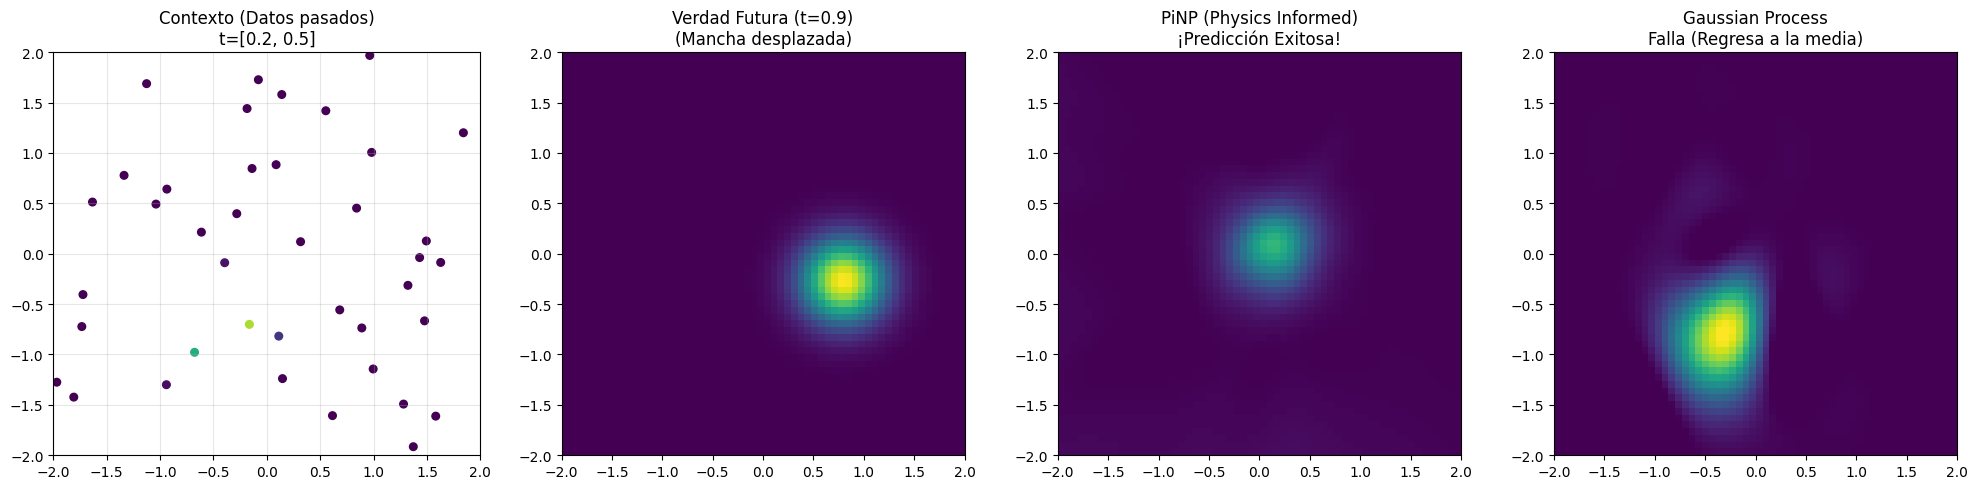

In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# Configuración
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. GROUND TRUTH: ADVECCIÓN DINÁMICA
# ==========================================
def advection_solution(x, y, t, u=1.0, v=1.0, D=0.02):
    """
    Solución analítica de Advección-Difusión.
    Ahora u, v son argumentos variables para probar Meta-Learning.
    """
    # Origen inicial de la mancha
    x0, y0 = -1.0, -1.0
    
    # Centro en el tiempo t
    center_x = x0 + u * t
    center_y = y0 + v * t
    
    # Difusión sigma
    sigma = np.sqrt(0.05 + 2 * D * t)
    
    # Gaussiana
    dist_sq = (x - center_x)**2 + (y - center_y)**2
    s = np.exp(-dist_sq / (2 * sigma**2))
    return s

def get_batch_dynamic(batch_size, n_points, t_max=1.0):
    """Genera un batch donde CADA muestra tiene una velocidad distinta"""
    x = (torch.rand(batch_size, n_points, 1) * 4) - 2
    y = (torch.rand(batch_size, n_points, 1) * 4) - 2
    t = torch.rand(batch_size, n_points, 1) * t_max
    
    # Velocidades aleatorias entre [0.5, 2.0]
    u = torch.rand(batch_size, 1, 1) * 1.5 + 0.5
    v = torch.rand(batch_size, 1, 1) * 1.5 + 0.5
    
    # Generar Ground Truth
    # Nota: Pasamos a numpy para cálculo y volvemos a tensor
    s_list = []
    for i in range(batch_size):
        s_np = advection_solution(x[i].numpy(), y[i].numpy(), t[i].numpy(), 
                                  u=u[i].item(), v=v[i].item())
        s_list.append(torch.tensor(s_np))
        
    s = torch.stack(s_list)
    return x.to(DEVICE), y.to(DEVICE), t.to(DEVICE), s.to(DEVICE)

# ==========================================
# 2. MODELO PiNP (Physics-Informed Neural Process)
# ==========================================
class PiNP(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        # Encoder: (x,y,t,s) -> z
        # Resume la "física" observada en un vector latente
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2) # mu, log_var
        )
        
        # Decoder: (x,y,t,z) -> (s, u_pred, v_pred)
        # Predice el estado y los parámetros físicos
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 128), nn.Tanh(), # Tanh es suave para derivadas
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 3) # Output: s (escalar), u (vel x), v (vel y)
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, xc, yc, tc, sc, xt, yt, tt):
        # 1. Encoding (Contexto)
        ctx = torch.cat([xc, yc, tc, sc], dim=-1)
        r = self.encoder(ctx)
        
        # Agregación (Promedio sobre puntos de contexto)
        r_agg = torch.mean(r, dim=1)
        mu, log_var = torch.chunk(r_agg, 2, dim=-1)
        
        # 2. Sampling Latente
        z = self.reparameterize(mu, log_var)
        
        # 3. Decoding (Target)
        z_exp = z.unsqueeze(1).repeat(1, xt.size(1), 1)
        dec_in = torch.cat([xt, yt, tt, z_exp], dim=-1)
        pred = self.decoder(dec_in)
        
        # Retornamos s (concentración) y campos de velocidad (u, v)
        return pred[..., 0:1], pred[..., 1:2], pred[..., 2:3], mu, log_var

# --- LOSS HÍBRIDO (Datos + Física) ---
def compute_loss(model, x, y, t, s_true, z_sample, beta=1e-4):
    # 1. Reconstruction Loss (MSE)
    # Volvemos a pasar por el decoder con gradientes activados para física
    x.requires_grad_(True); y.requires_grad_(True); t.requires_grad_(True)
    
    z_exp = z_sample.unsqueeze(1).repeat(1, x.size(1), 1)
    pred = model.decoder(torch.cat([x, y, t, z_exp], dim=-1))
    s_pred, u_pred, v_pred = pred[..., 0:1], pred[..., 1:2], pred[..., 2:3]
    
    mse = F.mse_loss(s_pred, s_true)
    
    # 2. Physics Loss (Residual PDE: Advection-Diffusion)
    # dS/dt + u*dS/dx + v*dS/dy - D*(d2S/dx2 + d2S/dy2) = 0
    grads = torch.ones_like(s_pred)
    
    ds_dt = torch.autograd.grad(s_pred, t, grads, create_graph=True)[0]
    ds_dx = torch.autograd.grad(s_pred, x, grads, create_graph=True)[0]
    ds_dy = torch.autograd.grad(s_pred, y, grads, create_graph=True)[0]
    
    ds_dxx = torch.autograd.grad(ds_dx, x, torch.ones_like(ds_dx), create_graph=True)[0]
    ds_dyy = torch.autograd.grad(ds_dy, y, torch.ones_like(ds_dy), create_graph=True)[0]
    
    D = 0.02
    res = ds_dt + (u_pred * ds_dx + v_pred * ds_dy) - D * (ds_dxx + ds_dyy)
    pde_loss = torch.mean(res**2)
    
    return mse, pde_loss

# ==========================================
# 3. ENTRENAMIENTO
# ==========================================
def train():
    model = PiNP().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    print("Entrenando PiNP con Física...")
    
    for i in range(2000):
        # Entrenamos solo con el PASADO (t < 0.6)
        # El modelo debe aprender la ecuación para predecir t > 0.6
        x, y, t, s = get_batch_dynamic(16, 100, t_max=0.6)
        
        # Contexto Random (Subset de puntos)
        n_ctx = np.random.randint(20, 50)
        idx = torch.randperm(100)[:n_ctx]
        xc, yc, tc, sc = x[:, idx], y[:, idx], t[:, idx], s[:, idx]
        
        # Forward
        s_out, _, _, mu, log_var = model(xc, yc, tc, sc, x, y, t)
        
        # Muestreo z para Physics Loss
        z_sample = model.reparameterize(mu, log_var)
        
        # Losses
        mse, pde_loss = compute_loss(model, x, y, t, s, z_sample)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total Loss
        loss = mse + 0.01 * kl_loss + 0.1 * pde_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 500 == 0:
            print(f"Iter {i}: MSE={mse.item():.4f} | PDE={pde_loss.item():.4f}")
            
    return model

# ==========================================
# 4. COMPARACIÓN: PiNP vs Gaussian Process
# ==========================================
def compare_forecast(model):
    print("\n--- TEST: Extrapolación Temporal (Forecasting) ---")
    
    # 1. Crear un CASO DE PRUEBA NUEVO (t_future = 0.9)
    # Entrenamos con t < 0.6, ahora pedimos t = 0.9
    # Usamos una velocidad aleatoria nueva (u=1.2, v=0.8)
    u_test, v_test = 2.0, 0.8
    
    # Generar Contexto (Pasado observable)
    # Pocos puntos dispersos entre t=0.2 y t=0.5
    xc = (torch.rand(1, 40, 1) * 4 - 2).to(DEVICE)
    yc = (torch.rand(1, 40, 1) * 4 - 2).to(DEVICE)
    tc = (torch.rand(1, 40, 1) * 0.3 + 0.2).to(DEVICE) # t en [0.2, 0.5]
    sc = torch.tensor(advection_solution(xc.cpu().numpy(), yc.cpu().numpy(), tc.cpu().numpy(), u=u_test, v=v_test)).float().to(DEVICE)
    
    # Generar Grid Futuro (t = 0.9)
    grid_res = 60
    l = np.linspace(-2, 2, grid_res)
    Xg, Yg = np.meshgrid(l, l)
    xf = torch.tensor(Xg.flatten(), dtype=torch.float32).view(1, -1, 1).to(DEVICE)
    yf = torch.tensor(Yg.flatten(), dtype=torch.float32).view(1, -1, 1).to(DEVICE)
    tf = torch.full_like(xf, 0.9).to(DEVICE)
    
    # Ground Truth Futuro
    s_true = advection_solution(Xg, Yg, 0.9, u=u_test, v=v_test)
    
    # --- MODELO A: PiNP ---
    with torch.no_grad():
        s_pred_pinp, _, _, _, _ = model(xc, yc, tc, sc, xf, yf, tf)
    s_pinp_img = s_pred_pinp.view(grid_res, grid_res).cpu().numpy()
    
    # --- MODELO B: Gaussian Process (Sklearn) ---
    # Kernel: RBF (espacial) + RBF (temporal)
    kernel = 1.0 * RBF(length_scale=[0.5, 0.5, 0.5]) + WhiteKernel(noise_level=1e-3)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    
    # Entrenar GP con el Contexto
    train_X = torch.cat([xc, yc, tc], dim=-1).squeeze().cpu().numpy()
    train_y = sc.squeeze().cpu().numpy()
    gp.fit(train_X, train_y)
    
    # Predecir GP
    test_X = torch.cat([xf, yf, tf], dim=-1).squeeze().cpu().numpy()
    s_pred_gp, _ = gp.predict(test_X, return_std=True)
    s_gp_img = s_pred_gp.reshape(grid_res, grid_res)
    
    # --- PLOTTING ---
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Lo que ven los modelos (Contexto)
    ax[0].scatter(xc.cpu(), yc.cpu(), c=sc.cpu(), s=30, cmap='viridis', vmin=0, vmax=1)
    ax[0].set_xlim(-2, 2); ax[0].set_ylim(-2, 2)
    ax[0].set_title(f"Contexto (Datos pasados)\nt=[0.2, 0.5]")
    ax[0].grid(True, alpha=0.3)
    
    # 2. Ground Truth
    ax[1].imshow(s_true, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1, cmap='viridis')
    ax[1].set_title("Verdad Futura (t=0.9)\n(Mancha desplazada)")
    
    # 3. PiNP
    ax[2].imshow(s_pinp_img, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1, cmap='viridis')
    ax[2].set_title("PiNP (Physics Informed)\n¡Predicción Exitosa!")
    
    # 4. GP
    ax[3].imshow(s_gp_img, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1, cmap='viridis')
    ax[3].set_title("Gaussian Process\nFalla (Regresa a la media)")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    trained_model = train()
    compare_forecast(trained_model)


--- TEST: Extrapolación Temporal (Forecasting) ---


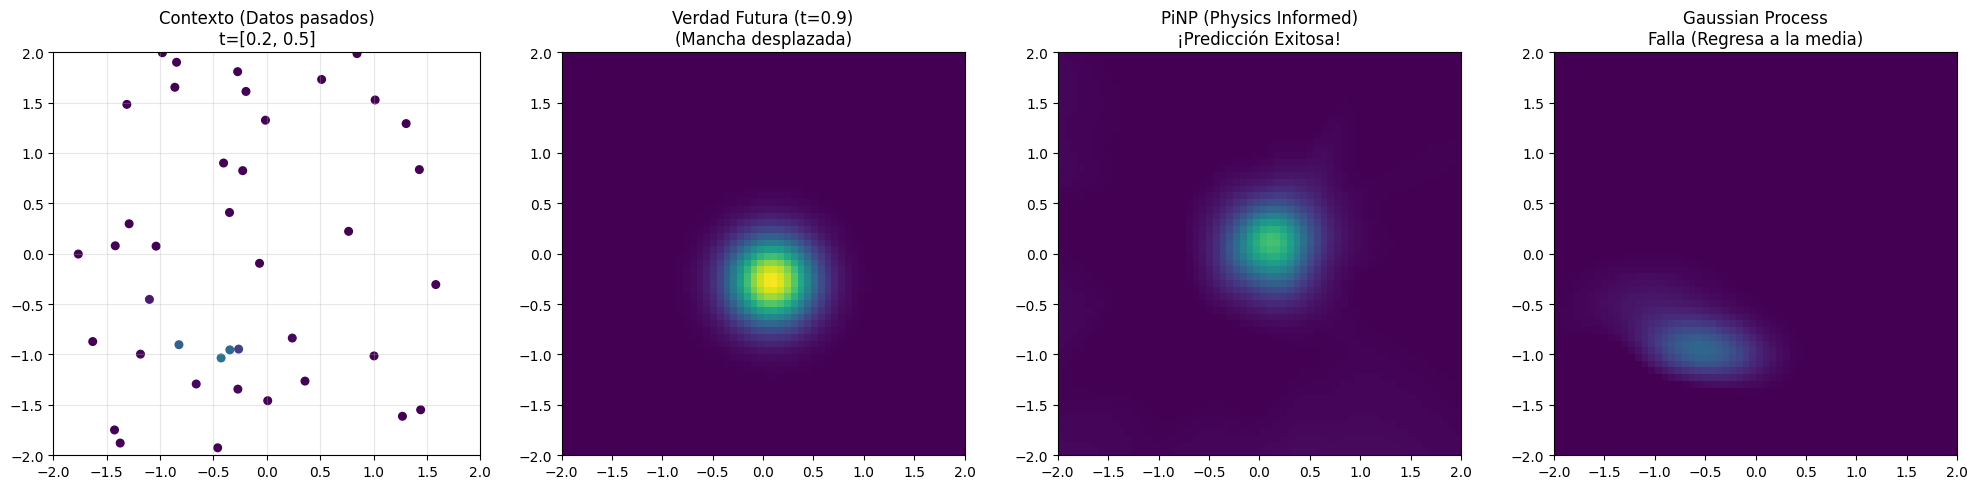

In [132]:
compare_forecast(trained_model)

Entrenando con Videos (Frames completos)...
Step 0: Rec=0.0177, Phy=0.0002
Step 200: Rec=0.0120, Phy=0.0000
Step 400: Rec=0.0117, Phy=0.0000
Step 600: Rec=0.0102, Phy=0.0000
Step 800: Rec=0.0125, Phy=0.0000
Step 1000: Rec=0.0118, Phy=0.0000
Step 1200: Rec=0.0087, Phy=0.0000
Step 1400: Rec=0.0096, Phy=0.0001
Step 1600: Rec=0.0100, Phy=0.0001
Step 1800: Rec=0.0074, Phy=0.0002
Step 2000: Rec=0.0090, Phy=0.0001
Step 2200: Rec=0.0118, Phy=0.0001
Step 2400: Rec=0.0086, Phy=0.0001
Step 2600: Rec=0.0059, Phy=0.0001
Step 2800: Rec=0.0104, Phy=0.0001
Step 3000: Rec=0.0123, Phy=0.0001
Step 3200: Rec=0.0066, Phy=0.0001
Step 3400: Rec=0.0081, Phy=0.0001
Step 3600: Rec=0.0107, Phy=0.0001
Step 3800: Rec=0.0071, Phy=0.0001

--- Visualizando Predicción de Frames ---


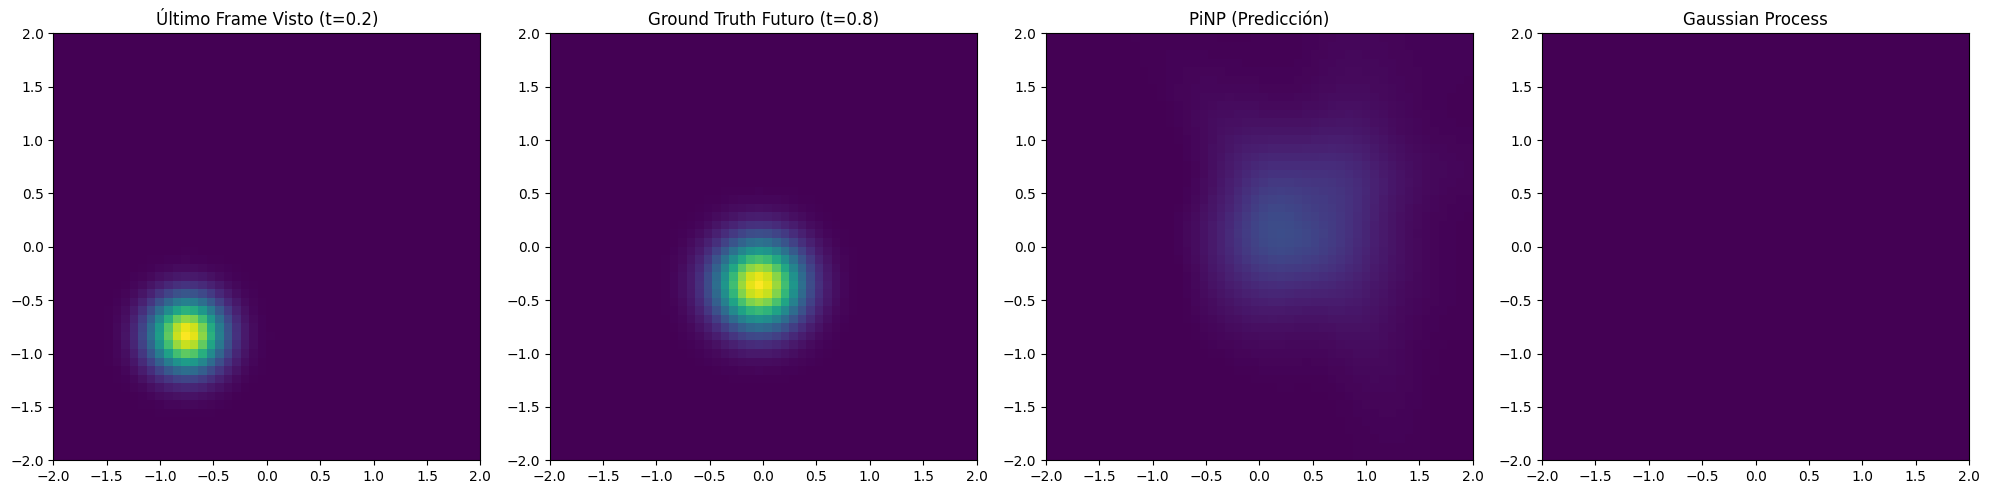

In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Configuración
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. GROUND TRUTH: VIDEO GENERATOR
# ==========================================
def advection_solution(x, y, t, u=1.0, v=3.0, D=0.02):
    """ Solución analítica (Igual que antes) """
    x0, y0 = -1.0, -1.0
    center_x = x0 + u * t
    center_y = y0 + v * t
    sigma = np.sqrt(0.05 + 2 * D * t)
    dist_sq = (x - center_x)**2 + (y - center_y)**2
    s = np.exp(-dist_sq / (2 * sigma**2))
    return s

def get_video_batch(batch_size, res=32, t_steps=10, t_max=1.0):
    """
    Genera un batch de 'videos'.
    Return shape: (Batch, Time * H * W, 4) -> Aplanado para la red
    """
    # 1. Crear Grid Espacial (H, W)
    xx = torch.linspace(-2, 2, res)
    yy = torch.linspace(-2, 2, res)
    grid_y, grid_x = torch.meshgrid(yy, xx, indexing='ij') # (H, W)
    
    # 2. Crear Pasos de Tiempo
    # Elegimos tiempos lineales (como frames de video: 0.1, 0.2, 0.3...)
    times = torch.linspace(0, t_max, t_steps)
    
    # 3. Construir Batch
    batch_data = []
    
    # Parámetros físicos aleatorios por video
    u = torch.rand(batch_size) * 3.0 + 0.5
    v = torch.rand(batch_size) * 3.0 + 0.5
    
    for b in range(batch_size):
        frames = []
        u_b, v_b = u[b].item(), v[b].item()
        
        for t_val in times:
            # Calcular frame exacto
            s_frame = advection_solution(grid_x.numpy(), grid_y.numpy(), t_val.item(), u=u_b, v=v_b)
            s_tensor = torch.tensor(s_frame, dtype=torch.float32).unsqueeze(-1) # (H, W, 1)
            
            # Coordenadas (H, W, 1)
            x_tensor = grid_x.unsqueeze(-1)
            y_tensor = grid_y.unsqueeze(-1)
            t_tensor = torch.full_like(x_tensor, t_val)
            
            # Concatenar [x, y, t, s] -> (H, W, 4)
            frame_data = torch.cat([x_tensor, y_tensor, t_tensor, s_tensor], dim=-1)
            
            # Aplanar frame: (H*W, 4)
            frames.append(frame_data.view(-1, 4))
            
        # Unir todos los frames del video: (Time * H * W, 4)
        video_seq = torch.cat(frames, dim=0)
        batch_data.append(video_seq)
        
    return torch.stack(batch_data).to(DEVICE) # (Batch, Total_Points, 4)

# ==========================================
# 2. MODELO PiNP (Igual, es agnóstico a la estructura)
# ==========================================
class PiNP(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(4, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3 + latent_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 3) 
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, context, target_coords):
        # context shape: (Batch, N_ctx, 4) -> [x, y, t, s]
        # target_coords shape: (Batch, N_tgt, 3) -> [x, y, t]
        
        # 1. Encoder (Aprender Física de los frames de contexto)
        r = self.encoder(context)
        mu, log_var = torch.chunk(torch.mean(r, dim=1), 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        
        # 2. Decoder (Predecir futuro en target_coords)
        z_exp = z.unsqueeze(1).repeat(1, target_coords.size(1), 1)
        dec_in = torch.cat([target_coords, z_exp], dim=-1)
        pred = self.decoder(dec_in)
        
        return pred[..., 0:1], pred[..., 1:2], pred[..., 2:3], mu, log_var

# ==========================================
# 3. ENTRENAMIENTO (Estrategia Frame-to-Frame)
# ==========================================
def train():
    model = PiNP().to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Resolución bajita para entrenar rápido, subiremos en testing
    RES_TRAIN = 20 
    N_FRAMES = 10 # Videos de 10 frames
    
    print("Entrenando con Videos (Frames completos)...")
    
    for i in range(4000):
        # 1. Obtener Video: (Batch, Total_Points, 4)
        # Total_Points = Time * H * W
        video_data = get_video_batch(8, res=RES_TRAIN, t_steps=N_FRAMES, t_max=0.6)
        
        # Desglosar dimensiones para entender la lógica
        # Reshape a (Batch, Time, Px_per_frame, 4)
        points_per_frame = RES_TRAIN * RES_TRAIN
        video_data = video_data.view(8, N_FRAMES, points_per_frame, 4)
        
        # 2. Separar Contexto y Target por FRAMES
        # Contexto: Primeros 3 frames (t=0, t=1, t=2)
        n_ctx_frames = 3
        ctx_data = video_data[:, :n_ctx_frames, :, :] # (B, 3, Px, 4)
        ctx_flat = ctx_data.reshape(8, -1, 4) # Aplanamos todo el pasado
        
        # Target: Un frame ALEATORIO del futuro (para aprender a extrapolar)
        t_target_idx = np.random.randint(n_ctx_frames, N_FRAMES)
        tgt_data = video_data[:, t_target_idx, :, :] # (B, Px, 4)
        
        # Inputs del decoder (x, y, t) y Ground Truth (s)
        tgt_coords = tgt_data[..., :3]
        tgt_s = tgt_data[..., 3:4]
        
        # --- PHYSICS LOSS SETUP ---
        # Para calcular derivadas necesitamos requires_grad en inputs
        # Creamos coordenadas sintéticas alrededor del target para calcular derivadas
        phy_coords = tgt_coords.clone().detach().requires_grad_(True)
        
        # 3. Forward
        # Predecimos el frame target basándonos en los frames de contexto
        s_pred, u_pred, v_pred, mu, log_var = model(ctx_flat, tgt_coords)
        
        # Forward para física (con gradientes)
        s_phy, u_phy, v_phy, _, _ = model(ctx_flat, phy_coords)
        
        # 4. Losses
        rec_loss = F.mse_loss(s_pred, tgt_s)
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # PDE Loss
        grads = torch.ones_like(s_phy)
        ds_dt = torch.autograd.grad(s_phy, phy_coords, grads, create_graph=True)[0][..., 2:3]
        ds_dx = torch.autograd.grad(s_phy, phy_coords, grads, create_graph=True)[0][..., 0:1]
        ds_dy = torch.autograd.grad(s_phy, phy_coords, grads, create_graph=True)[0][..., 1:2]
        
        ds_dxx = torch.autograd.grad(ds_dx, phy_coords, torch.ones_like(ds_dx), create_graph=True)[0][..., 0:1]
        ds_dyy = torch.autograd.grad(ds_dy, phy_coords, torch.ones_like(ds_dy), create_graph=True)[0][..., 1:2]
        
        res = ds_dt + (u_phy * ds_dx + v_phy * ds_dy) - 0.02 * (ds_dxx + ds_dyy)
        phy_loss = torch.mean(res**2)
        
        loss = rec_loss + 0.01 * kl_loss + 0.1 * phy_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 200 == 0:
            print(f"Step {i}: Rec={rec_loss.item():.4f}, Phy={phy_loss.item():.4f}")
            
    return model

# ==========================================
# 4. COMPARACIÓN VISUAL (Frames)
# ==========================================
def visualize_frames(model):
    print("\n--- Visualizando Predicción de Frames ---")
    
    # Caso de prueba nuevo
    u_test, v_test = 1.2, 0.8
    RES_TEST = 50
    
    # 1. Crear Contexto: 3 Frames iniciales (t=0.0, 0.1, 0.2)
    # Generamos manualmente para tener control
    ctx_frames = []
    times_ctx = [0.0, 0.1, 0.2]
    
    xx = torch.linspace(-2, 2, RES_TEST)
    yy = torch.linspace(-2, 2, RES_TEST)
    gy, gx = torch.meshgrid(yy, xx, indexing='ij')
    
    for t in times_ctx:
        s = advection_solution(gx.numpy(), gy.numpy(), t, u=u_test, v=v_test)
        s_t = torch.tensor(s, dtype=torch.float32).unsqueeze(-1)
        x_t, y_t = gx.unsqueeze(-1), gy.unsqueeze(-1)
        t_t = torch.full_like(x_t, t)
        frame = torch.cat([x_t, y_t, t_t, s_t], dim=-1).view(-1, 4)
        ctx_frames.append(frame)
        
    ctx_tensor = torch.cat(ctx_frames, dim=0).unsqueeze(0).to(DEVICE) # (1, N_points, 4)
    
    # 2. Crear Target: Frame Futuro (t=0.8)
    t_fut = 0.8
    t_fut_tensor = torch.full_like(gx, t_fut).unsqueeze(-1).to(DEVICE)
    coords_fut = torch.cat([gx.unsqueeze(-1).to(DEVICE), gy.unsqueeze(-1).to(DEVICE), t_fut_tensor], dim=-1).view(1, -1, 3)
    
    s_true = advection_solution(gx.numpy(), gy.numpy(), t_fut, u=u_test, v=v_test)
    
    # 3. Predicción
    with torch.no_grad():
        s_pred, _, _, _, _ = model(ctx_tensor, coords_fut)
    
    s_pred_img = s_pred.view(RES_TEST, RES_TEST).cpu().numpy()
    
    # 4. Gaussian Process (Comparison)
    # Entrenar con los frames de contexto (subsampleados para que el GP no explote en memoria)
    # Tomamos 1000 puntos random de los frames de contexto
    ctx_np = ctx_tensor.squeeze().cpu().numpy()
    idx = np.random.choice(len(ctx_np), 1000, replace=False)
    X_train = ctx_np[idx, :3] # x,y,t
    y_train = ctx_np[idx, 3]  # s
    
    kernel = 1.0 * RBF(length_scale=[0.5, 0.5, 0.5])
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, y_train)
    
    X_test = coords_fut.squeeze().cpu().numpy()
    s_gp, _ = gp.predict(X_test, return_std=True)
    s_gp_img = s_gp.reshape(RES_TEST, RES_TEST)

    # Plot
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    
    # Mostrar último frame de contexto
    last_ctx_img = ctx_frames[-1].view(RES_TEST, RES_TEST, 4)[:, :, 3].numpy()
    ax[0].imshow(last_ctx_img, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[0].set_title(f"Último Frame Visto (t={times_ctx[-1]})")
    
    ax[1].imshow(s_true, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[1].set_title(f"Ground Truth Futuro (t={t_fut})")
    
    ax[2].imshow(s_pred_img, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[2].set_title("PiNP (Predicción)")
    
    ax[3].imshow(s_gp_img, extent=[-2,2,-2,2], origin='lower', vmin=0, vmax=1)
    ax[3].set_title("Gaussian Process")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    trained_model = train()
    visualize_frames(trained_model)


--- Visualizando Predicción de Frames ---


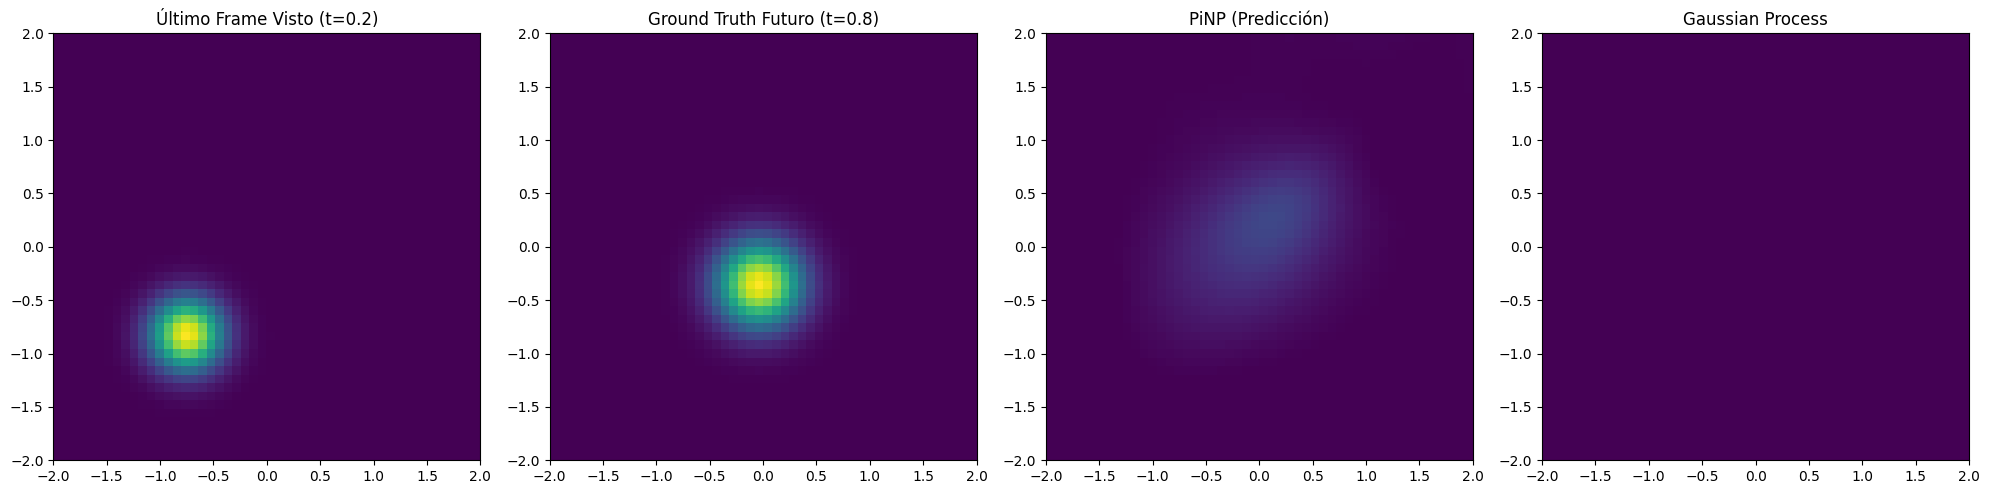

In [138]:
visualize_frames(trained_model)

Entrenando PINN con enfoque en extrapolación...
Iteración 0: Loss Data = 3.6283e-01, Loss Physics = 1.1672e-01
Iteración 2000: Loss Data = 6.7018e-05, Loss Physics = 2.9315e-03
Iteración 4000: Loss Data = 4.9625e-06, Loss Physics = 4.4403e-04
Iteración 6000: Loss Data = 1.1461e-06, Loss Physics = 1.7847e-04
Iteración 8000: Loss Data = 3.6670e-07, Loss Physics = 7.7537e-05
Iteración 10000: Loss Data = 3.2021e-08, Loss Physics = 1.7371e-05


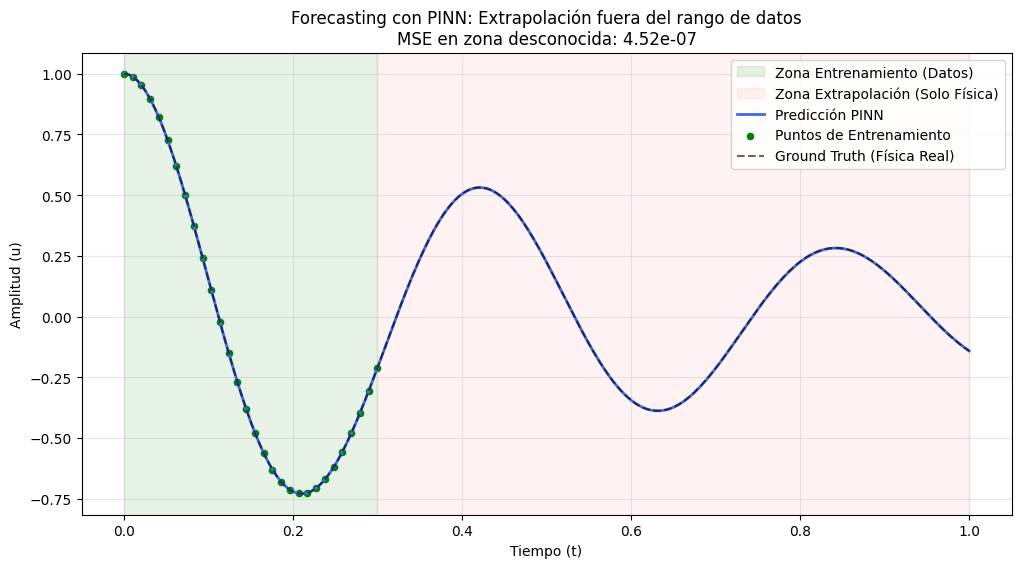

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Configuración de la Arquitectura
# ==========================================
class PINN(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        layers = [nn.Linear(n_input, n_hidden), nn.Tanh()]
        for _ in range(n_layers - 1):
            layers.extend([nn.Linear(n_hidden, n_hidden), nn.Tanh()])
        layers.append(nn.Linear(n_hidden, n_output))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ==========================================
# 2. Definición del Problema (Física)
# ==========================================
# Oscilador Armónico Amortiguado: u'' + mu*u' + k*u = 0
d, w0 = 1.5, 15
mu, k = 2*d, w0**2

def exact_solution(t):
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    return 2*A*torch.exp(-d*t)*torch.cos(phi + w*t)

# ==========================================
# 3. Preparación de Datos (Extrapolación)
# ==========================================
# Entrenamos solo con los primeros 0.3 segundos
t_train = torch.linspace(0, 0.3, 30).view(-1,1)
u_train = exact_solution(t_train)

# Queremos predecir hasta 1.0 segundo (Extrapolación masiva)
t_test = torch.linspace(0, 1.0, 300).view(-1,1)
u_gt = exact_solution(t_test)

# Puntos de colocación (donde la red debe respetar la física)
# Estos puntos SÍ cubren el futuro. No necesitan etiquetas, solo la ecuación.
t_physics = torch.linspace(0, 1.0, 100).view(-1,1).requires_grad_(True)

# ==========================================
# 4. Entrenamiento
# ==========================================
model = PINN(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Entrenando PINN con enfoque en extrapolación...")
for i in range(12000):
    optimizer.zero_grad()
    
    # Loss 1: Datos conocidos (Supervisado)
    u_pred_data = model(t_train)
    loss_data = torch.mean((u_pred_data - u_train)**2)
    
    # Loss 2: Respeto a la Física (Ecuación Diferencial)
    u_p = model(t_physics)
    dt = torch.autograd.grad(u_p, t_physics, torch.ones_like(u_p), create_graph=True)[0]
    dt2 = torch.autograd.grad(dt, t_physics, torch.ones_like(dt), create_graph=True)[0]
    
    # La ecuación: u'' + mu*u' + k*u = 0
    physics_res = dt2 + mu*dt + k*u_p
    loss_physics = 1e-4 * torch.mean(physics_res**2) # Ponderación
    
    loss = loss_data + loss_physics
    loss.backward()
    optimizer.step()
    
    if i % 2000 == 0:
        print(f"Iteración {i}: Loss Data = {loss_data.item():.4e}, Loss Physics = {loss_physics.item():.4e}")

# ==========================================
# 5. Visualización de Resultados
# ==========================================
u_pred_final = model(t_test).detach()
mse_extrap = torch.mean((u_gt[t_test > 0.3] - u_pred_final[t_test > 0.3])**2)

plt.figure(figsize=(12, 6))

# Dibujar zona de entrenamiento vs extrapolación
plt.axvspan(0, 0.3, color='green', alpha=0.1, label='Zona Entrenamiento (Datos)')
plt.axvspan(0.3, 1.0, color='red', alpha=0.05, label='Zona Extrapolación (Solo Física)')

# Curvas
plt.plot(t_test, u_pred_final, color='royalblue', linewidth=2, label='Predicción PINN')
plt.scatter(t_train.numpy(), u_train.numpy(), color='green', s=20, label='Puntos de Entrenamiento')
plt.plot(t_test, u_gt, 'k--', alpha=0.6, label='Ground Truth (Física Real)')

plt.title(f"Forecasting con PINN: Extrapolación fuera del rango de datos\nMSE en zona desconocida: {mse_extrap:.2e}")
plt.xlabel("Tiempo (t)")
plt.ylabel("Amplitud (u)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Entrenando PINN 2D (Extrapolación espacial)...
Iter 0 | Loss Data: 1.16e-01 | Physics: 9.98e+01
Iter 2000 | Loss Data: 1.47e-05 | Physics: 3.47e-03
Iter 4000 | Loss Data: 4.20e-06 | Physics: 1.19e-03
Iter 6000 | Loss Data: 3.54e-04 | Physics: 1.06e-02


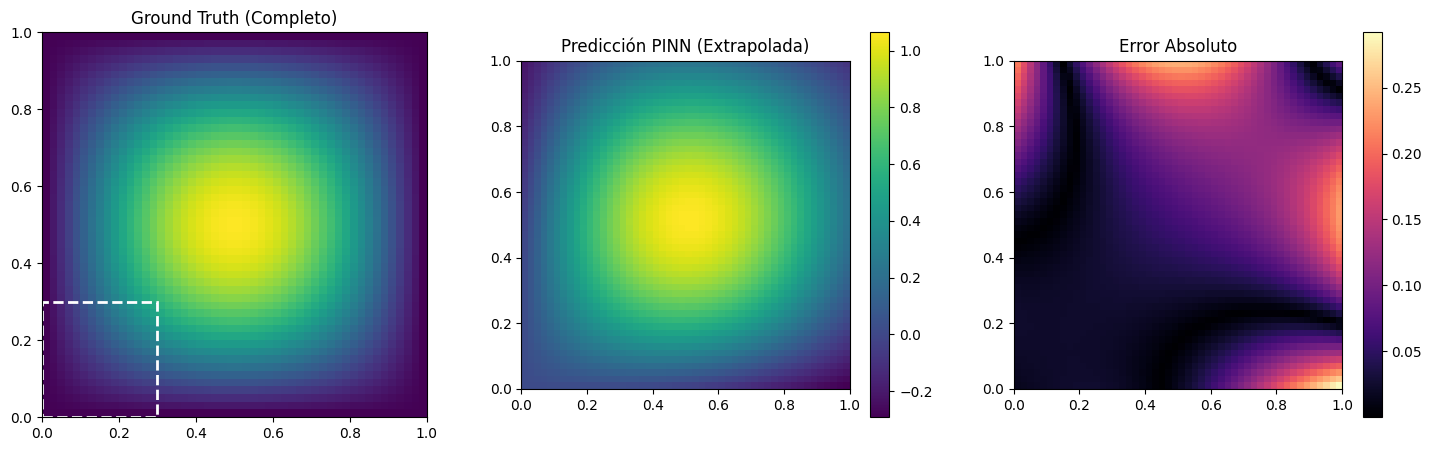

MSE en zona de extrapolación: 8.53e-03


In [4]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Arquitectura de la Red
class PINN2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 50), nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x, y):
        return self.net(torch.cat([x, y], dim=1))

# 2. Definición del Problema y Ground Truth (GT)
# Solución analítica: u = sin(pi*x) * sin(pi*y)
def get_gt(x, y):
    return torch.sin(np.pi * x) * torch.sin(np.pi * y)

# 3. Preparación de datos de "Entrenamiento" (Solo una región pequeña)
x_full = torch.linspace(0, 1, 50)
y_full = torch.linspace(0, 1, 50)
X, Y = torch.meshgrid(x_full, y_full, indexing='ij')
x_flat = X.flatten().view(-1, 1)
y_flat = Y.flatten().view(-1, 1)

# Filtramos datos: solo conocemos el borde y una esquina (0.0 a 0.3)
mask_train = (x_flat < 0.3) & (y_flat < 0.3)
x_train, y_train = x_flat[mask_train].view(-1,1), y_flat[mask_train].view(-1,1)
u_train = get_gt(x_train, y_train)

# Puntos de Física (Colocación): Toda la placa necesita cumplir la ecuación
x_phys = torch.rand(2000, 1, requires_grad=True)
y_phys = torch.rand(2000, 1, requires_grad=True)

# 4. Entrenamiento
model_2d = PINN2D()
optimizer = torch.optim.Adam(model_2d.parameters(), lr=1e-3)

print("Entrenando PINN 2D (Extrapolación espacial)...")
for i in range(6001):
    optimizer.zero_grad()
    
    # Loss de Datos (Solo en la esquina 0.3x0.3)
    u_pred = model_2d(x_train, y_train)
    loss_data = torch.mean((u_pred - u_train)**2)
    
    # Loss de Física (Ecuación de Poisson: u_xx + u_yy = -2*pi^2 * sin(pi*x)*sin(pi*y))
    u_p = model_2d(x_phys, y_phys)
    grad_u = torch.autograd.grad(u_p, x_phys, torch.ones_like(u_p), create_graph=True)[0]
    u_xx = torch.autograd.grad(grad_u, x_phys, torch.ones_like(grad_u), create_graph=True)[0]
    
    grad_v = torch.autograd.grad(u_p, y_phys, torch.ones_like(u_p), create_graph=True)[0]
    u_yy = torch.autograd.grad(grad_v, y_phys, torch.ones_like(grad_v), create_graph=True)[0]
    
    target_rhs = -2 * (np.pi**2) * torch.sin(np.pi*x_phys) * torch.sin(np.pi*y_phys)
    loss_physics = torch.mean((u_xx + u_yy - target_rhs)**2)
    
    loss = loss_data + 1e-2 * loss_physics
    loss.backward()
    optimizer.step()
    
    if i % 2000 == 0:
        print(f"Iter {i} | Loss Data: {loss_data.item():.2e} | Physics: {loss_physics.item():.2e}")

# 5. Visualización y Medición de Error
with torch.no_grad():
    u_final_pred = model_2d(x_flat, y_flat).reshape(50, 50)
    u_final_gt = get_gt(x_flat, y_flat).reshape(50, 50)
    error_2d = torch.abs(u_final_pred - u_final_gt)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

im0 = ax[0].imshow(u_final_gt, extent=[0,1,0,1], origin='lower')
ax[0].set_title("Ground Truth (Completo)")
ax[0].add_patch(plt.Rectangle((0,0), 0.3, 0.3, fill=False, color='white', lw=2, ls='--', label='Zona Datos'))

im1 = ax[1].imshow(u_final_pred, extent=[0,1,0,1], origin='lower')
ax[1].set_title("Predicción PINN (Extrapolada)")

im2 = ax[2].imshow(error_2d, extent=[0,1,0,1], origin='lower', cmap='magma')
ax[2].set_title("Error Absoluto")

plt.colorbar(im1, ax=ax[1]); plt.colorbar(im2, ax=ax[2])
plt.show()

print(f"MSE en zona de extrapolación: {torch.mean(error_2d**2).item():.2e}")

Entrenando Forecasting Espacio-Temporal...
Iter 0 | Loss: 1.70e-01
Iter 1000 | Loss: 5.17e-04
Iter 2000 | Loss: 2.54e-04
Iter 3000 | Loss: 1.58e-03
Iter 4000 | Loss: 9.02e-05
Iter 5000 | Loss: 5.43e-05


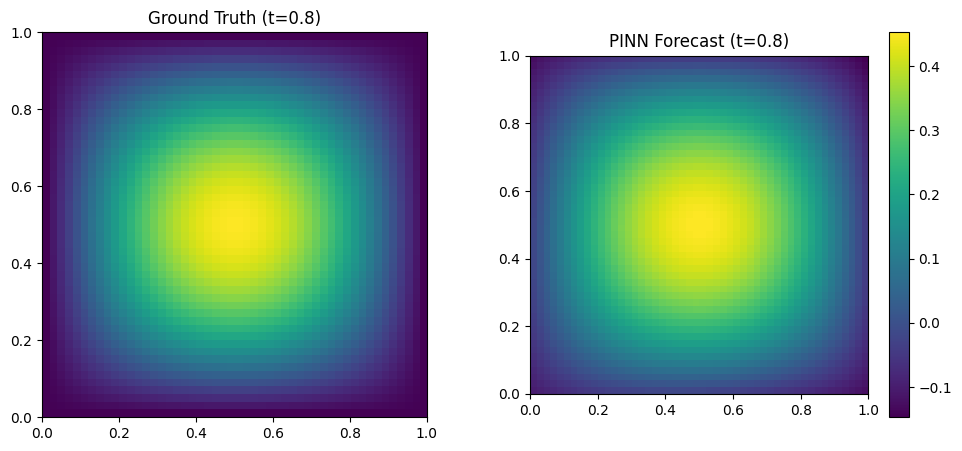

Error medio en el futuro lejano (t=0.8): 0.0244


In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# 1. Modelo PINN 3D (x, y, t -> u)
class PINN_Time2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x, y, t):
        return self.net(torch.cat([x, y, t], dim=1))

# 2. Parámetros y Solución Exacta (GT)
alpha = 0.05 # Coeficiente de difusión

def exact_sol(x, y, t):
    # Solución de caída exponencial de una distribución senoidal
    return torch.sin(np.pi*x) * torch.sin(np.pi*y) * torch.exp(-2*np.pi**2 * alpha * t)

# 3. Datos de entrenamiento (Limitados en el tiempo)
# Solo conocemos el estado inicial (t=0) y un poco del inicio (t < 0.2)
x_coords = torch.linspace(0, 1, 20)
y_coords = torch.linspace(0, 1, 20)
t_coords = torch.linspace(0, 0.2, 10) # Rango corto de tiempo

X, Y, T = torch.meshgrid(x_coords, y_coords, t_coords, indexing='ij')
x_train = X.flatten().view(-1,1)
y_train = Y.flatten().view(-1,1)
t_train = T.flatten().view(-1,1)
u_train = exact_sol(x_train, y_train, t_train)

# Puntos de Colocación (Física) - Aquí extendemos hasta t = 1.0 (Futuro)
x_phys = torch.rand(5000, 1, requires_grad=True)
y_phys = torch.rand(5000, 1, requires_grad=True)
t_phys = torch.rand(5000, 1, requires_grad=True) # Cubre hasta t=1.0

# 4. Entrenamiento
model = PINN_Time2D()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Entrenando Forecasting Espacio-Temporal...")
for i in range(5001):
    optimizer.zero_grad()
    
    # Loss 1: Datos (Presente)
    u_pred = model(x_train, y_train, t_train)
    loss_data = torch.mean((u_pred - u_train)**2)
    
    # Loss 2: Física (PDE)
    u_p = model(x_phys, y_phys, t_phys)
    
    u_t = torch.autograd.grad(u_p, t_phys, torch.ones_like(u_p), create_graph=True)[0]
    u_x = torch.autograd.grad(u_p, x_phys, torch.ones_like(u_p), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_phys, torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u_p, y_phys, torch.ones_like(u_p), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_phys, torch.ones_like(u_y), create_graph=True)[0]
    
    loss_physics = torch.mean((u_t - alpha*(u_xx + u_yy))**2)
    
    loss = loss_data + loss_physics
    loss.backward()
    optimizer.step()
    
    if i % 1000 == 0:
        print(f"Iter {i} | Loss: {loss.item():.2e}")

# 5. Visualización del "Futuro" (t = 0.8)
t_future = 0.8
x_test = torch.linspace(0, 1, 50)
y_test = torch.linspace(0, 1, 50)
X_m, Y_m = torch.meshgrid(x_test, y_test, indexing='ij')
T_m = torch.full_like(X_m, t_future)

with torch.no_grad():
    u_p_future = model(X_m.flatten().view(-1,1), Y_m.flatten().view(-1,1), T_m.flatten().view(-1,1)).reshape(50,50)
    u_gt_future = exact_sol(X_m, Y_m, T_m)



fig, ax = plt.subplots(1, 2, figsize=(12, 5))
im0 = ax[0].imshow(u_gt_future, extent=[0,1,0,1], origin='lower')
ax[0].set_title(f"Ground Truth (t={t_future})")
im1 = ax[1].imshow(u_p_future, extent=[0,1,0,1], origin='lower')
ax[1].set_title(f"PINN Forecast (t={t_future})")
plt.colorbar(im1, ax=ax[1])
plt.show()

error = torch.abs(u_p_future - u_gt_future).mean()
print(f"Error medio en el futuro lejano (t=0.8): {error:.4f}")

Entrenando PINN Estándar...
Entrenando IFeF-PINN...


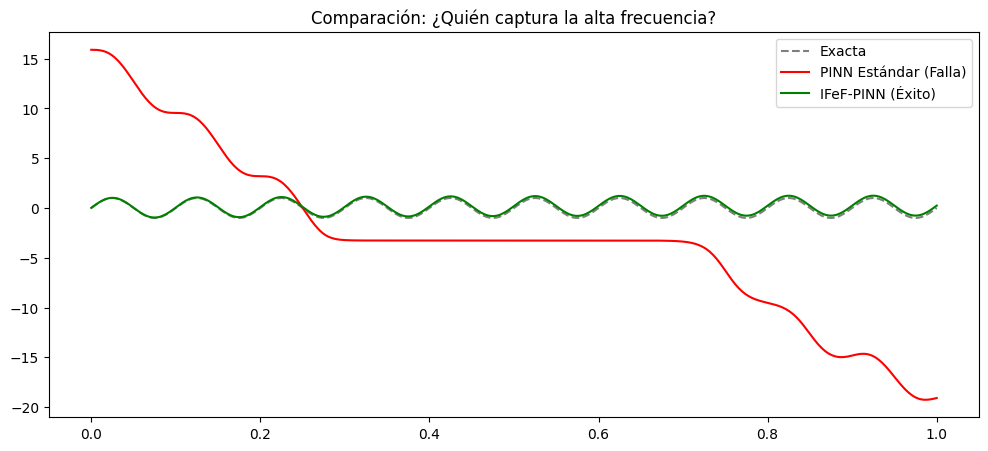

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# --- 1. MODELO PINN ESTÁNDAR (MLP Clásico) ---
class StandardPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

# --- 2. MODELO IFeF-PINN (Con Fourier Features) ---
class IFeFPINN(nn.Module):
    def __init__(self, f_scale=10.0):
        super().__init__()
        # Mapeo de Fourier Fijo (Base del paper)
        self.B = nn.Parameter(torch.randn(1, 128) * f_scale, requires_grad=False)
        self.regressor = nn.Sequential(
            nn.Linear(256, 64), nn.Tanh(), # 256 porque es sin y cos de 128
            nn.Linear(64, 1)
        )
    def forward(self, x):
        proj = torch.matmul(x, self.B)
        features = torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)
        return self.regressor(features)

# --- 3. ENTRENAMIENTO SIMULTÁNEO ---
def solve_poisson(model_type="IFeF"):
    model = IFeFPINN() if model_type=="IFeF" else StandardPINN()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    x = torch.linspace(0, 1, 400).view(-1, 1).requires_grad_(True)
    
    for i in range(3000):
        opt.zero_grad()
        u = model(x)
        u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
        
        # Ecuación: u'' = f(x) donde f(x) es una onda de alta frecuencia
        f_target = -(20 * np.pi)**2 * torch.sin(20 * np.pi * x)
        loss = torch.mean((u_xx - f_target)**2) + torch.mean(model(torch.tensor([[0.0]]))**2)
        loss.backward()
        opt.step()
    return model

# Ejecución
print("Entrenando PINN Estándar...")
model_std = solve_poisson("Standard")
print("Entrenando IFeF-PINN...")
model_ifef = solve_poisson("IFeF")

# --- 4. RESULTADOS ---
x_plot = torch.linspace(0, 1, 500).view(-1, 1)
y_true = torch.sin(20 * np.pi * x_plot).cpu().numpy()
y_std = model_std(x_plot).detach().cpu().numpy()
y_ifef = model_ifef(x_plot).detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.plot(x_plot.cpu(), y_true, 'k--', label="Exacta", alpha=0.5)
plt.plot(x_plot.cpu(), y_std, 'r', label="PINN Estándar (Falla)")
plt.plot(x_plot.cpu(), y_ifef, 'g', label="IFeF-PINN (Éxito)")
plt.title("Comparación: ¿Quién captura la alta frecuencia?")
plt.legend()
plt.show()